In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import missingno
import sqlite3

# Introduction
Battlefield 5 is a multiplayer first person shooter game developed by DICE and published by EA. It released on current generation Playstation and XBox consoles as well as PC in 2018. In this notebook, I determine whether the players can be segmented according to information about how they play the game. There are many ways one might segment the data in a rule-based fashion - according to platform, most played class, etc. Instead of doing this, I am interested in whether we can cluster players in some useful fashion according to various player metrics that are recorded and made available.

To do this, I scraped data off of [Battlefield Tracker](https://battlefieldtracker.com/). This comes with a caveat. While the game sold ar4ound 7.8 million copies, publicly available data only tracks about 1% of that. So in fact, this analysis really only tracks the top 10% of players snf dhoulf not be assumed to extend beyond that.

In [2]:
con = sqlite3.connect('bfvstats.db')
cur = con.cursor()

info = cur.execute('SELECT * FROM pragma_table_info("bfvstats")').fetchall() # column names (and other info)
query_cols = list(map(lambda x: x[1], info))[1:] # retrieve only names of columns I want to keep

In [3]:
con = sqlite3.connect('bfvstats.db')
cur = con.cursor()

info = cur.execute('SELECT * FROM pragma_table_info("bfvstats")').fetchall() # column names (and other info)
query_cols = list(map(lambda x: x[1], info))[1:] # retrieve list of names of columns I want to keep
query_cols = ','.join(query_cols)

df = pd.read_sql(f'SELECT {query_cols} FROM bfvstats', con)
df = df.drop(df.columns[0], axis=1)
df.head()

,platform,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,deaths_percentile,damage_value,...,Tanker_shotsFired_value,Tanker_shotsFired_percentile,Tanker_shotsHit_value,Tanker_shotsHit_percentile,Tanker_shotsAccuracy_value,Tanker_shotsAccuracy_percentile,Tanker_score_value,Tanker_score_percentile,Tanker_scorePerMinute_value,Tanker_scorePerMinute_percentile
0,psn,378.792295,71.0,2.620212,93.0,515490,99.9,196736,None,59433079,...,0.0,None,0.0,None,0.0,None,1780075.0,94.0,814.679634,64.0
1,psn,549.142755,96.6,5.595874,99.0,659401,99.9,117837,None,72180090,...,0.0,None,0.0,None,0.0,None,159756.0,69.0,420.410526,24.0
2,psn,252.147827,28.0,1.748259,79.0,423493,99.9,242237,None,51395987,...,0.0,None,0.0,None,0.0,None,84699.0,58.0,1693.980000,81.0
3,origin,668.252814,99.0,5.202617,98.9,938318,99.9,180355,None,107543331,...,0.0,None,0.0,None,0.0,None,9943381.0,99.5,748.410432,61.0
4,psn,316.174639,50.0,2.545317,93.0,444364,99.9,174581,None,51220628,...,0.0,None,0.0,None,0.0,None,35013.0,41.0,2059.588235,84.0


There are many features. Given I simply dumped data from an API into a csv file, and I suspect at least some features only took one unique value, I check to see if that is the case. Features taking only one value, whether NaN values or other values, are useless when applying machine learning methods, since they do not distinguish any sample from any other sample. This does not make such features useless per se (ex. suppose you learned everyone on Earth's favorite color was red; this would be very interesting if not useful for distinguishing between people).

In [4]:
null_features = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        null_features.append(col)
num_null_features = len(null_features)
print(f'There are {num_null_features} features with only one unique value')

There are 94 features with only one unique value


This is a lot of features. I expect many of them are percentiles, as eyeballing the JSON, it appeared not all of these features actually took non-None values. I check this assumption below.

In [5]:
null_percentile_features = []
null_other_features = []
for feature in null_features:
    if 'percentile' in feature:
        null_percentile_features.append(feature)
    else:
        null_other_features.append(feature)
num_percentile_null_features = len(null_percentile_features)
print(f'Of features taking only one unique value, {num_percentile_null_features} are percentiles.')
print(f'The other features taking only one unique value are below:')
null_other_features

Of features taking only one unique value, 93 are percentiles.
The other features taking only one unique value are below:


['rankScore_value']

Below I check to see if these features have unique values that are non-NaN and greater than zero, a value of zero being unreasonable for all of thousands of players.

In [6]:
non_null_count = 0
for feat in null_other_features + null_percentile_features:
    
    if  df[feat].unique()[0] != 0 and (not df[feat].isna().all()):
        print(f'{feat} takes a non-NaN value')
        non_null_count += 1
if non_null_count == 0:
    print('All of the scores take either NaN values or 0 as their only value.')

All of the scores take either NaN values or 0 as their only value.


We can discard the features discussed above as useless. While taking only a single value does not make a feature useless to any sort of analysis, the values these features take must mean that the features simply refer to metrics that were not stored. This is moreso obvious for anything taking a NaN value, but it simply could not be the case that every player on the leaderboard has an accuracy of zero with tanks - you could undoubtedly look up some of these players on Youtube to confirm that.

In [7]:
df.drop(null_other_features + null_percentile_features, axis=1, inplace=True)

In [8]:
df.head()

,platform,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,damage_value,damage_percentile,...,Tanker_killsPerMinute_value,Tanker_kdRatio_value,Tanker_timePlayed_value,Tanker_shotsFired_value,Tanker_shotsHit_value,Tanker_shotsAccuracy_value,Tanker_score_value,Tanker_score_percentile,Tanker_scorePerMinute_value,Tanker_scorePerMinute_percentile
0,psn,378.792295,71.0,2.620212,93.0,515490,99.9,196736,59433079,99.9,...,2.012815,0.0,131130.0,0.0,0.0,0.0,1780075.0,94.0,814.679634,64.0
1,psn,549.142755,96.6,5.595874,99.0,659401,99.9,117837,72180090,99.9,...,1.092105,0.0,22805.0,0.0,0.0,0.0,159756.0,69.0,420.410526,24.0
2,psn,252.147827,28.0,1.748259,79.0,423493,99.9,242237,51395987,99.9,...,3.400000,0.0,3025.0,0.0,0.0,0.0,84699.0,58.0,1693.980000,81.0
3,origin,668.252814,99.0,5.202617,98.9,938318,99.9,180355,107543331,99.9,...,2.757865,0.0,797160.0,0.0,0.0,0.0,9943381.0,99.5,748.410432,61.0
4,psn,316.174639,50.0,2.545317,93.0,444364,99.9,174581,51220628,99.9,...,1.294118,0.0,1040.0,0.0,0.0,0.0,35013.0,41.0,2059.588235,84.0


# Feature Engineering

## Convert Time Played Features to Hours
The time played features are given in seconds. I would prefer to have these in hours to make them easier to read.

In [9]:
for feature in df.columns:
    if 'timeplayed' in feature.lower():
        df[feature] /= 3600

## Scaling Features by Time Played
A number of features here are presented in raw values like damage_value, which gives the amount of damage a player has done while playing the game. This value, however, will be influenced by the amount of time a player has played the game. A more interpretable measure would be the amount of damage a player has done per unit of time played. To be consistent with features already in the dataset, I will scale time independent features on a per minute basis. I will not scale features that already have some per minute equivalent, like kills per minute or shot accuracy.

Note that this should not remove time dependence entirely. The average player who has only played 5 hours is likely to have fewer kills per minute than someone with 500 hours played because they have less familiarity with the game, for example.

In [10]:
features_to_scale = ['deaths_value', 'assists_value', 'assistsAsKills_value', 'dogtagsTaken_value', 'avengerKills_value', 'saviorKills_value', 'headshots_value', \
    'suppressionAssists_value', 'heals_value', 'revives_value', 'revivesRecieved_value', 'resupplies_value', 'repairs_value', 'aceSquad_value', 'squadSpawns_value', 'squadWipes_value', 'ordersCompleted_value',\
        'scoreMedic_value', 'scoreAssault_value', 'scoreSupport_value', 'scoreRecon_value', 'scoreAir_value', 'scoreLand_value', 'scoreTanks_value', 'scoreTransports_value', 'scoreRound_value',\
            'scoreGeneral_value', 'scoreCombat_value', 'scoreDefensive_value', 'scoreObjective_value', 'scoreBonus_value', 'scoreSquad_value', 'scoreAward_value']

for feature in features_to_scale:
    df[f'{feature}_PerMinute'] = df[feature]/(df['timePlayed_value'] * 60)

# Exploratory Data Analysis
There are enough features that plotting all of their distributions at once is a bit confusing. So I break the features into categories, one for each class, vehicle category and a catch all category for the rest. Then I plot each category separately.

In [11]:
medic_features = [ ]
assault_features = []
support_features = []
recon_features = []
ground_vehicle_features = []
plane_features = []
general_features = []

for feature in df.columns:
    if 'medic' in feature.lower():
        medic_features.append(feature)
    elif 'assault' in feature.lower():
        assault_features.append(feature)
    elif 'support' in feature.lower():
        support_features.append(feature)
    elif 'recon' in feature.lower():
        recon_features.append(feature)
    elif 'tank' in feature.lower() or 'transport' in feature.lower():
        ground_vehicle_features.append(feature)
    elif 'air' in feature.lower() or 'plane' in feature.lower() or 'pilot' in feature.lower():
        plane_features.append(feature)
    else:
        general_features.append(feature)


## General Features

In [12]:
df[general_features].describe()

,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,damage_value,damage_percentile,assists_value,...,ordersCompleted_value_PerMinute,scoreLand_value_PerMinute,scoreRound_value_PerMinute,scoreGeneral_value_PerMinute,scoreCombat_value_PerMinute,scoreDefensive_value_PerMinute,scoreObjective_value_PerMinute,scoreBonus_value_PerMinute,scoreSquad_value_PerMinute,scoreAward_value_PerMinute
count,7.836900e+04,77693.000000,78369.000000,78367.000000,78369.00000,78367.000000,78369.000000,7.836900e+04,78367.000000,78369.000000,...,78369.000000,78369.000000,7.836900e+04,78369.000000,7.836900e+04,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000
mean,6.497444e+02,56.879536,1.995922,63.240924,28733.90384,78.774071,14588.209292,3.481228e+06,78.982183,5934.641236,...,0.141530,39.684481,6.497032e+02,475.609345,4.541051e+02,92.619526,103.259939,53.057500,53.490010,92.196144
std,5.222353e+04,28.239113,51.858488,27.897565,46543.34926,18.520676,19827.303960,5.457305e+06,18.249067,8904.288174,...,0.110419,542.296922,5.222082e+04,168.455270,5.222057e+04,61.347915,53.343995,24.161761,140.743440,38.230469
min,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.046210,0.000000,5.283568,0.085566,0.000000
25%,2.673927e+02,33.000000,1.022634,42.000000,3537.00000,67.000000,2875.000000,4.530180e+05,68.000000,870.000000,...,0.083989,8.221565,2.673690e+02,375.481262,1.095606e+02,65.217592,69.196710,37.524968,37.419010,64.117131
50%,3.402142e+02,59.000000,1.495575,69.000000,10439.00000,84.000000,6947.000000,1.309892e+06,84.000000,2388.000000,...,0.125957,21.083987,3.402082e+02,458.455284,1.497879e+02,86.450688,95.805009,48.406996,49.501102,89.588510
75%,4.245913e+02,82.000000,2.163041,88.000000,32462.00000,94.000000,17724.000000,4.034307e+06,94.000000,7019.000000,...,0.181331,47.089809,4.245672e+02,552.070128,1.982471e+02,110.244612,128.357302,62.990470,63.944946,116.748612
max,1.420893e+07,99.900000,14416.000000,99.900000,938318.00000,99.900000,280591.000000,1.075433e+08,99.900000,172519.000000,...,5.067035,84569.382415,1.420824e+07,6015.863311,1.420807e+07,2693.983032,1886.080174,1881.566707,38760.259909,355.729101


This dataset contains many potential outliers (see, e.g., the kdRatio_value summary in the table above), which poses a problem when plotting histograms of certain features. By default, Seaborn uses the Freedman-Diaconis rulee. This calculates the number of bins as follows. 

$$h = \frac{2*IQR}{n^{1/3}}$$

Where IQR is the interquartile range (between the 25th and 75th percentile), and n is the number of samples. This is then used to compute the number of bins using the largest and smallest values in a feature

$$nbins = \frac{max - min}{h}$$

Where the interquartile range is small but the difference between maximum and minimum bins is large, the rule gives a very large number of bins. These will not only make histograms unreadable (with reasonable values binned into one small bin, many empty bins, and a nearly empty bin for larger values), which hides the distribution of the data, it also makes the histograms expensive to compute.

As a solution, where the Freedman-Diaconis rule gives too many bins (using a hand-picked threshold), I fall back to another rule, suggesting the number of bins should be equal to the square root of the number of samples in the dataset. I then place all of the values above 10 times the value at the 99th percentile in the same bin. This naturally distorts the distribution of the data as well, but it at least allows us to view how the grand majority of the data in features which have potential outliers.

In [13]:
def freedman_diaconis(sub_df, feature):
    '''
    Calculates the number of bins using the Freedman-Diaconis rule
    '''
    q_25 = np.quantile(sub_df, q=0.25)
    q_75 = np.quantile(sub_df, q=0.75)
    iqr = q_75-q_25
    width = 2*iqr*(len(sub_df)**(-1/3))
    n_bins = (np.max(sub_df) - np.min(sub_df))/width
    return int(n_bins)

def get_n_bins(df, feature, threshold):
    '''
    Calculates number of bins using freedman diaconis rule. If the rule leads to too many bins,
    return bins calculated using square root rule.
    '''
    sub_df = df[df[feature].notna()][feature]
    n_freedman = freedman_diaconis(sub_df, feature)
    if n_freedman > threshold:
        return int(np.sqrt(len(sub_df))), np.quantile(sub_df, q=0.99)
    else:
        return int(n_freedman), 'freedman'

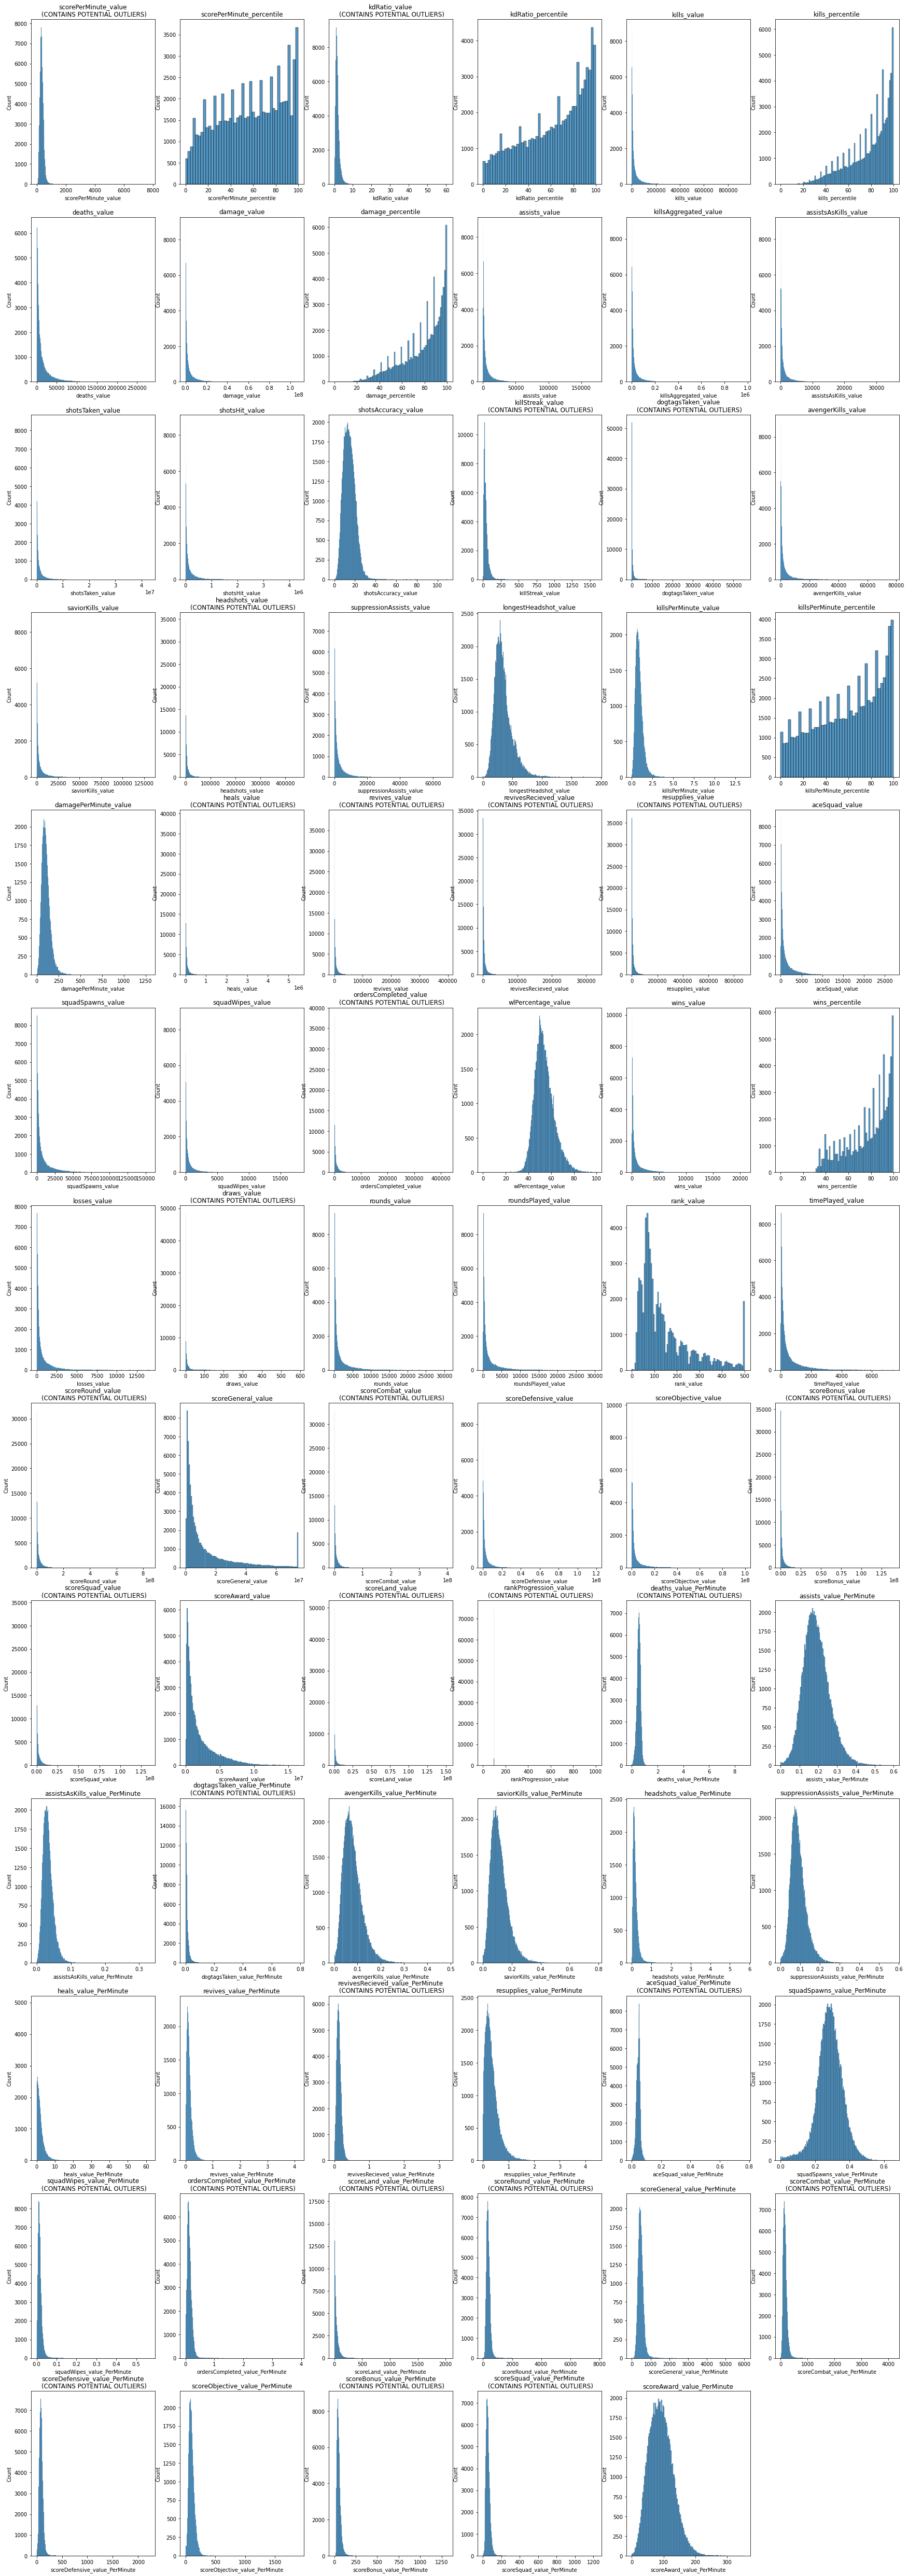

In [14]:
fig, axes = plt.subplots(13, 6, figsize=(30, 90))
for ax, feat in zip(np.ravel(axes), general_features[1:]):
    bins, max_range = get_n_bins(df, feat, 1000)
    
    if type(max_range) == str:
        sns.histplot(data=df, x=feat, ax=ax)
        ax.set_title(f'{feat}')
    else:
        sns.histplot(data=df, x=feat, ax=ax, bins=bins, binrange=(0, max_range*10))
        ax.set_title(f'{feat}\n (CONTAINS POTENTIAL OUTLIERS)')
        
for i, ax in enumerate(np.ravel(axes)):
        if i > len(general_features[1:])-1:
            ax.axis('off')

## Medic Features
Note for the medic and all other classes, we have score features scaled by two different time features. Features named with the form like "Medic_scorePerMinute_value" is the score for the medic scaled by time spent playing the class. Features named with the form "scoreMedic_value_PerMinute" are scaled by total time spent playing the game.

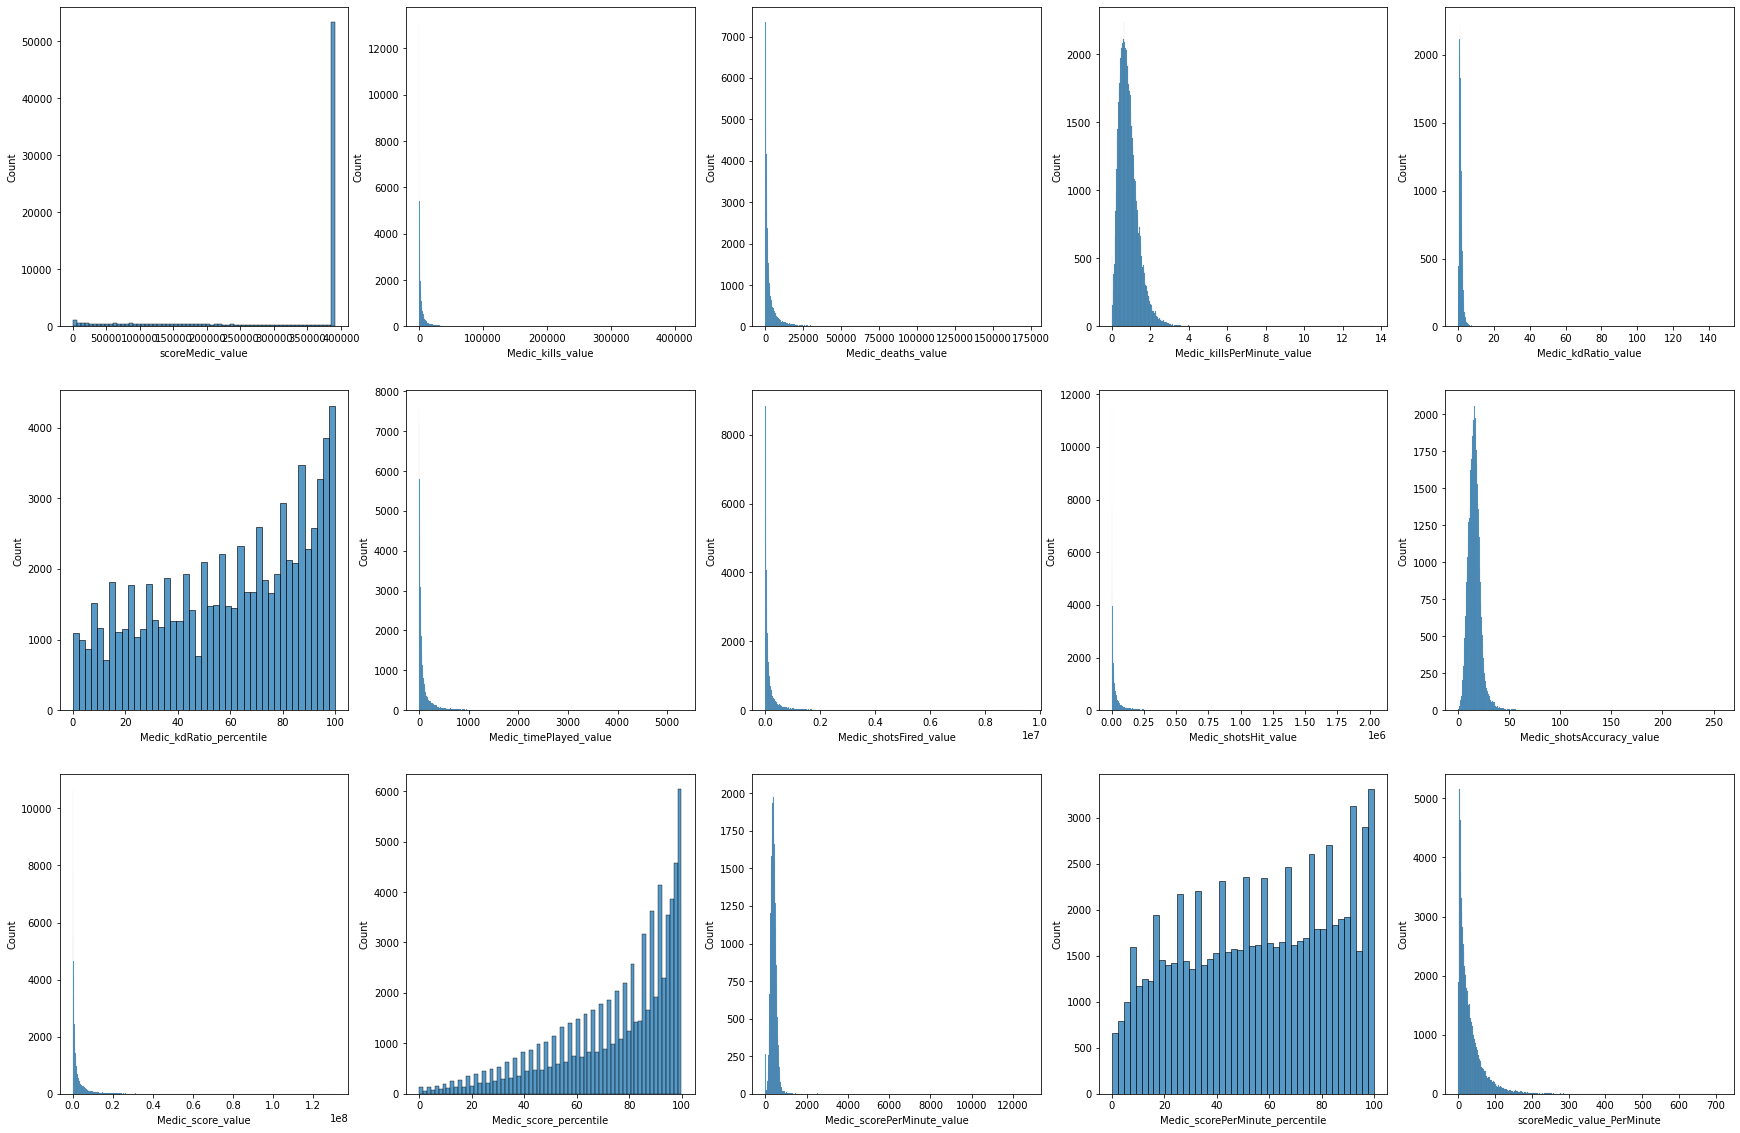

In [15]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), medic_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Assault Features

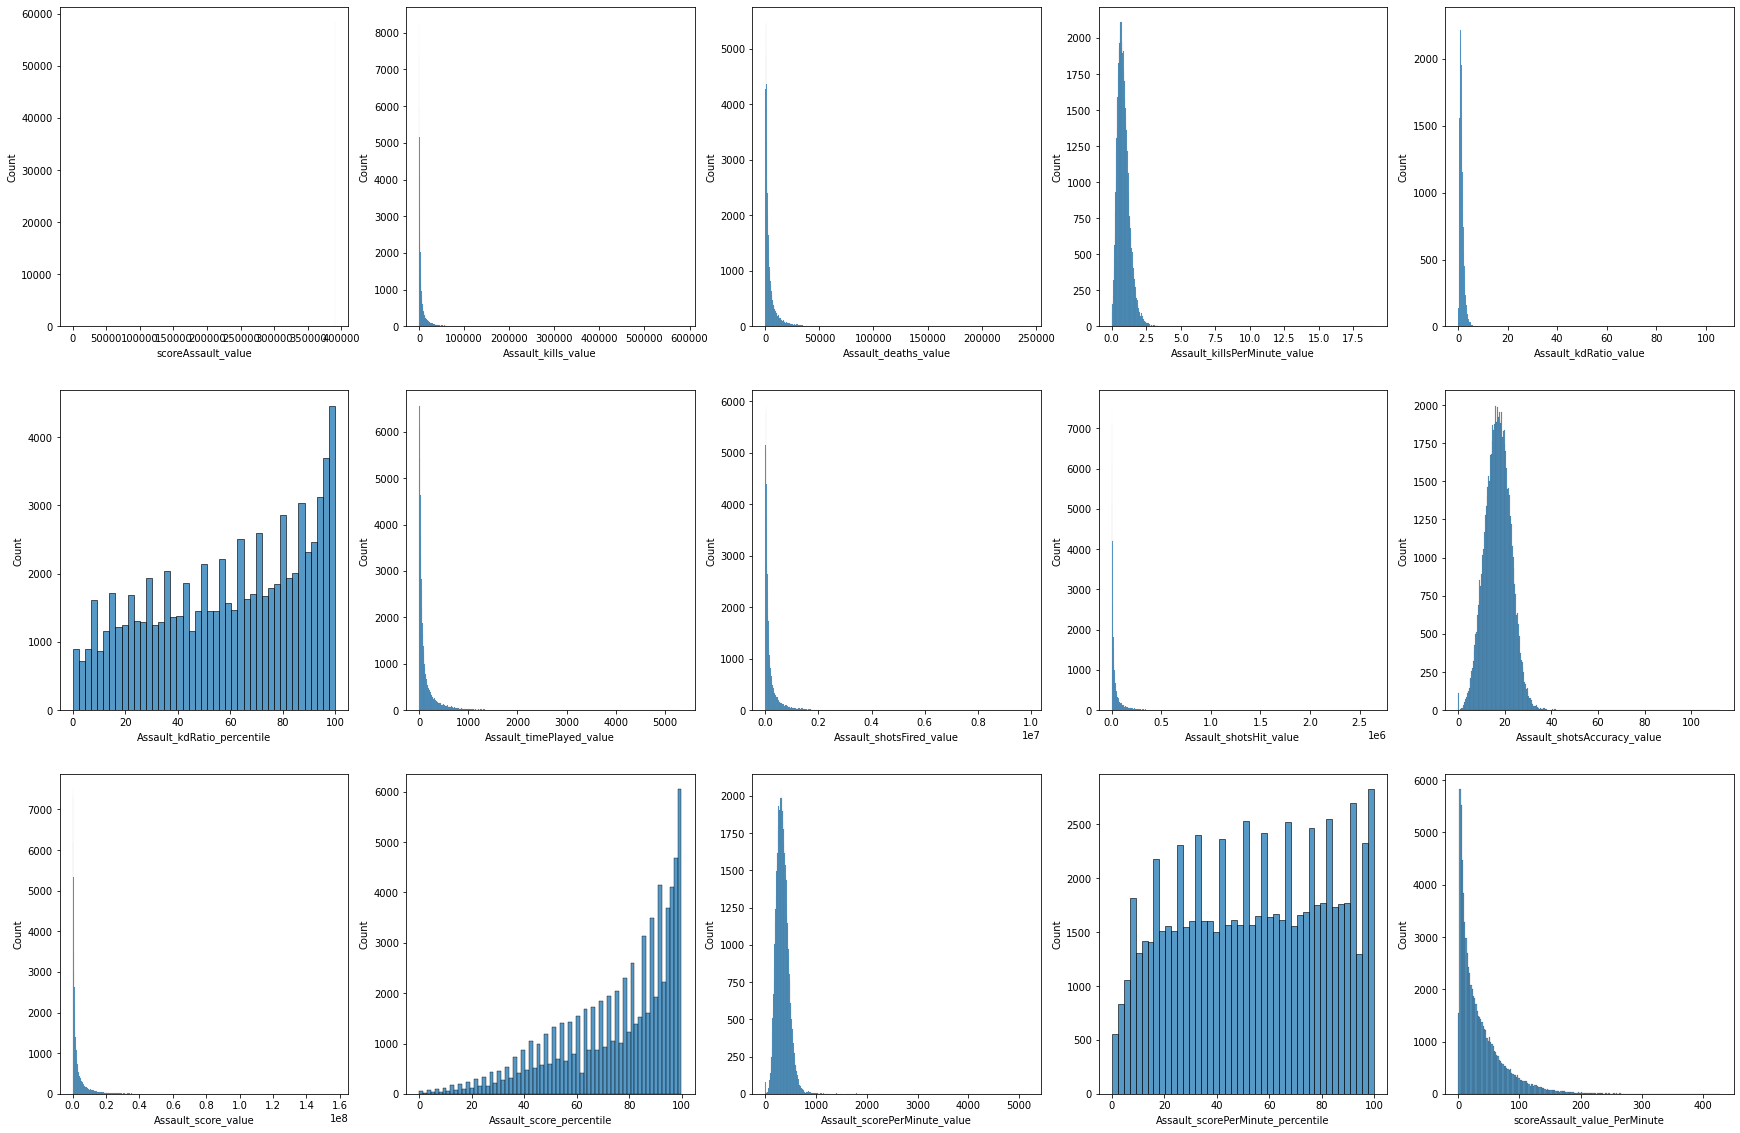

In [16]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), assault_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Support Features

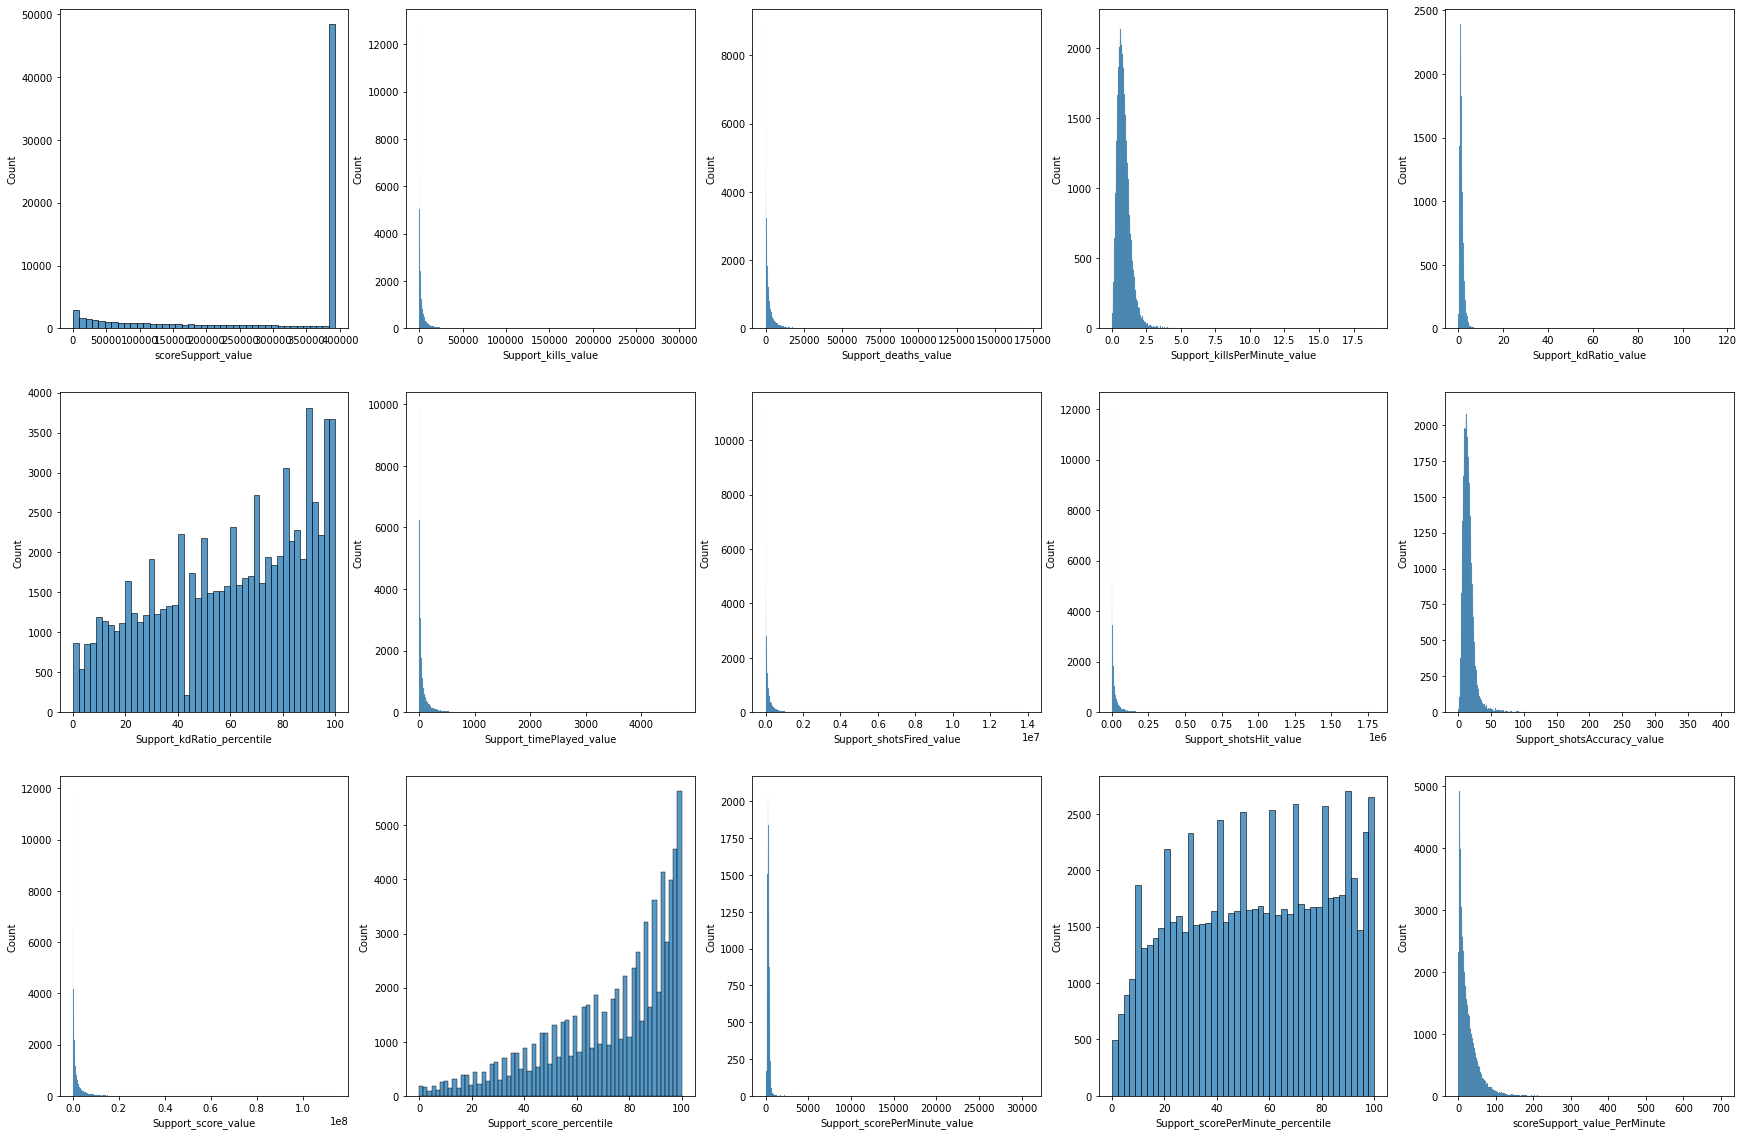

In [17]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), support_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Recon Features

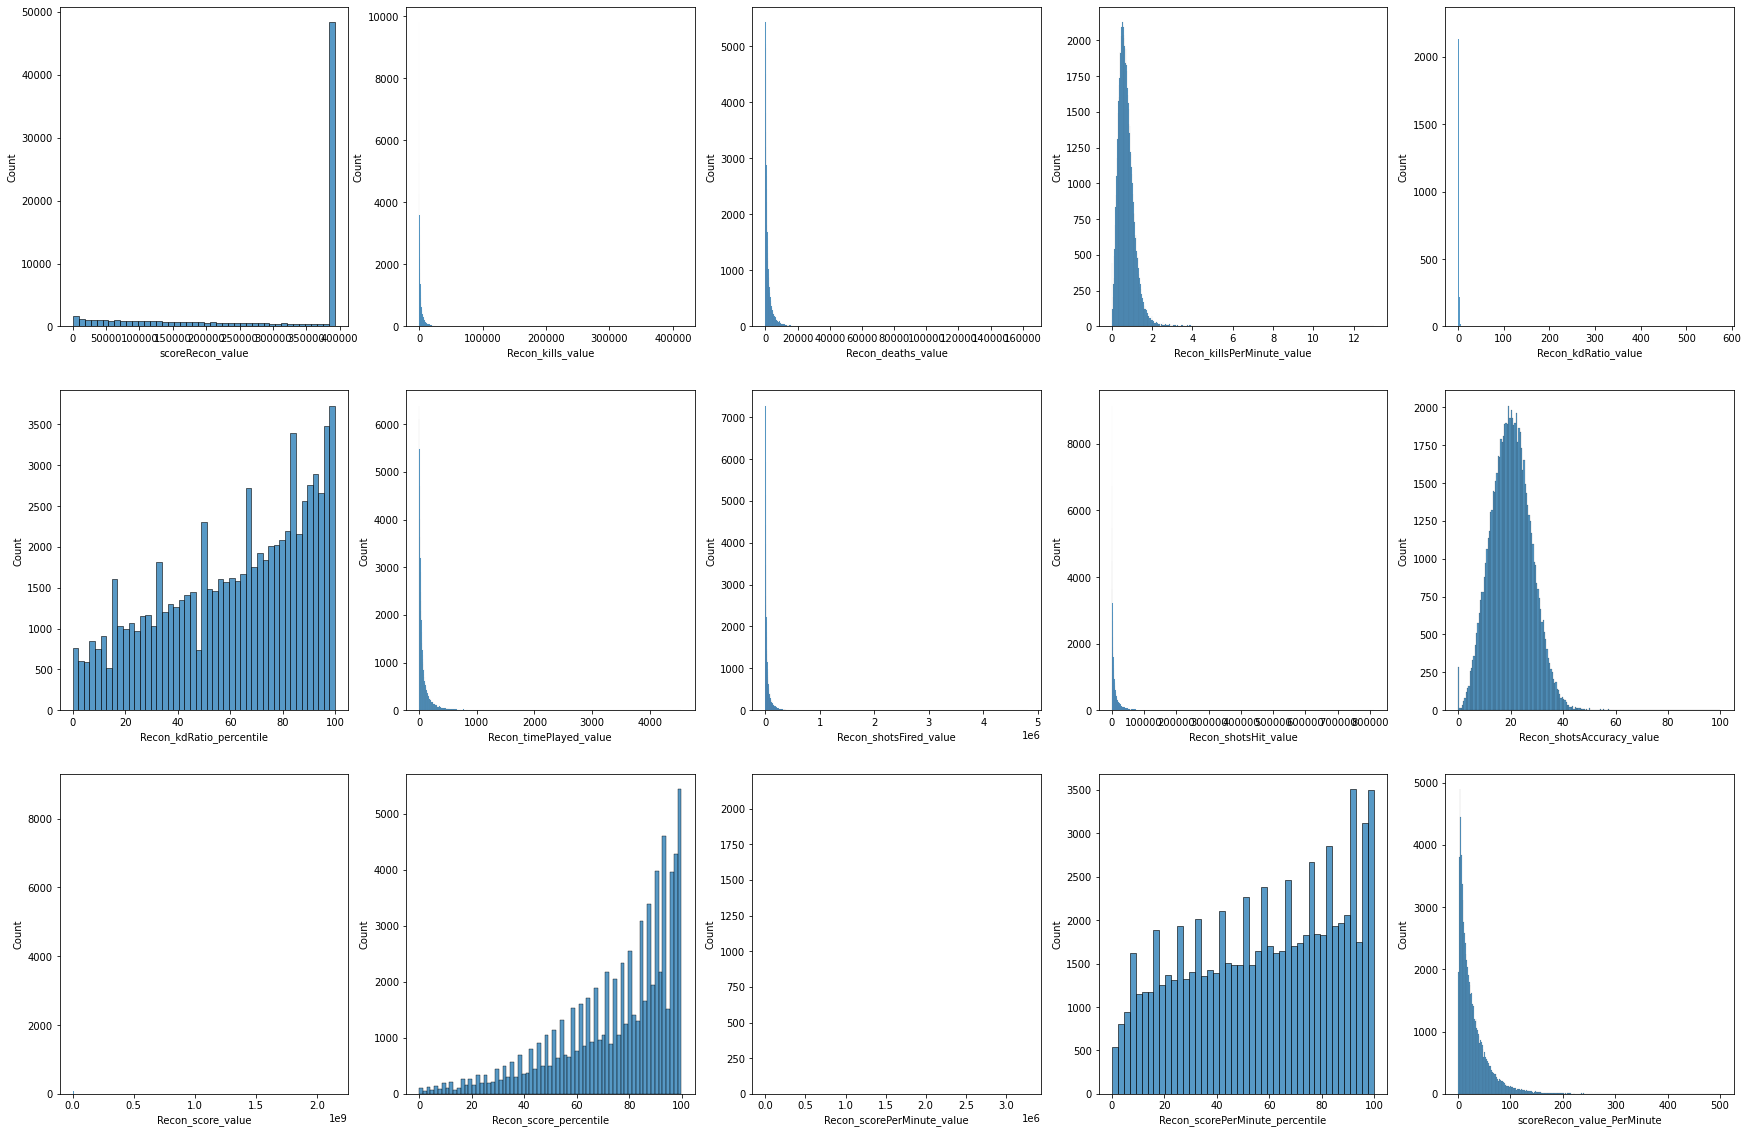

In [19]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), recon_features):
    sns.histplot(data=df, x=feat, ax=ax)
    
plt.show()

## Ground Vehicle Features

In [20]:
df[ground_vehicle_features].describe()

,scoreTanks_value,scoreTransports_value,Tanker_kills_value,Tanker_deaths_value,Tanker_killsPerMinute_value,Tanker_kdRatio_value,Tanker_timePlayed_value,Tanker_shotsFired_value,Tanker_shotsHit_value,Tanker_shotsAccuracy_value,Tanker_score_value,Tanker_score_percentile,Tanker_scorePerMinute_value,Tanker_scorePerMinute_percentile,scoreTanks_value_PerMinute,scoreTransports_value_PerMinute
count,7.836900e+04,7.836900e+04,78367.000000,78367.0,78367.000000,78367.0,78367.000000,78367.0,78367.0,78367.0,7.836700e+04,78276.000000,7.836700e+04,78276.000000,78369.000000,78369.000000
mean,1.193531e+06,1.008640e+05,3198.790767,0.0,4.560673,0.0,39.764867,0.0,0.0,0.0,1.296732e+06,69.582322,3.305807e+03,52.079910,35.944871,3.653305
std,6.316049e+06,7.423130e+05,9138.905543,0.0,21.640318,0.0,109.571312,0.0,0.0,0.0,6.408202e+06,25.100242,2.386260e+04,28.264827,541.240534,32.114166
min,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,4.614800e+04,1.036900e+04,110.000000,0.0,1.008282,0.0,0.847222,0.0,0.0,0.0,6.370850e+04,53.000000,4.495538e+02,29.000000,5.850787,1.117535
50%,2.125960e+05,2.730800e+04,542.000000,0.0,1.397626,0.0,6.702778,0.0,0.0,0.0,2.621960e+05,76.000000,6.100436e+02,51.000000,17.439308,2.180385
75%,8.989690e+05,7.987600e+04,2395.000000,0.0,2.265550,0.0,32.607639,0.0,0.0,0.0,1.020796e+06,91.000000,1.281406e+03,76.000000,42.723570,3.997245
max,8.564936e+08,7.149225e+07,291672.000000,0.0,2277.000000,0.0,5321.491667,0.0,0.0,0.0,8.565328e+08,99.900000,2.463586e+06,99.900000,84565.515180,5729.772068


We can see that some features do not contain any non-zero values. These features are not particularly useful and can be dropped. We see also potential outliers, like the large maximum value for Tanker_killsPerMinute_value.

In [21]:
useless_ground_features = [feat for feat in ground_vehicle_features if len(df[df[feat].notna()][feat].unique()) == 1]
ground_vehicle_features = [feat for feat in ground_vehicle_features if feat not in useless_ground_features]
df = df.drop(useless_ground_features, axis=1)
useless_ground_features

['Tanker_deaths_value',
 'Tanker_kdRatio_value',
 'Tanker_shotsFired_value',
 'Tanker_shotsHit_value',
 'Tanker_shotsAccuracy_value']

It is worth pausing here to note that not all large values are likely to be outliers. Consider the range of values for the Tanker_timePlayed_value. The 75th percentile is around 63 hours, while the maximum is over 5300 hours. This is a niche part of the game relative to non-vehicle gameplay. Based on prior knowledge, it would make sense that most people would barely use this feature but a few would use the feature quite a lot.

On the other hand, the maximum value of a feature like Tanker_killsPerMinute_value is almost certainly an outlier

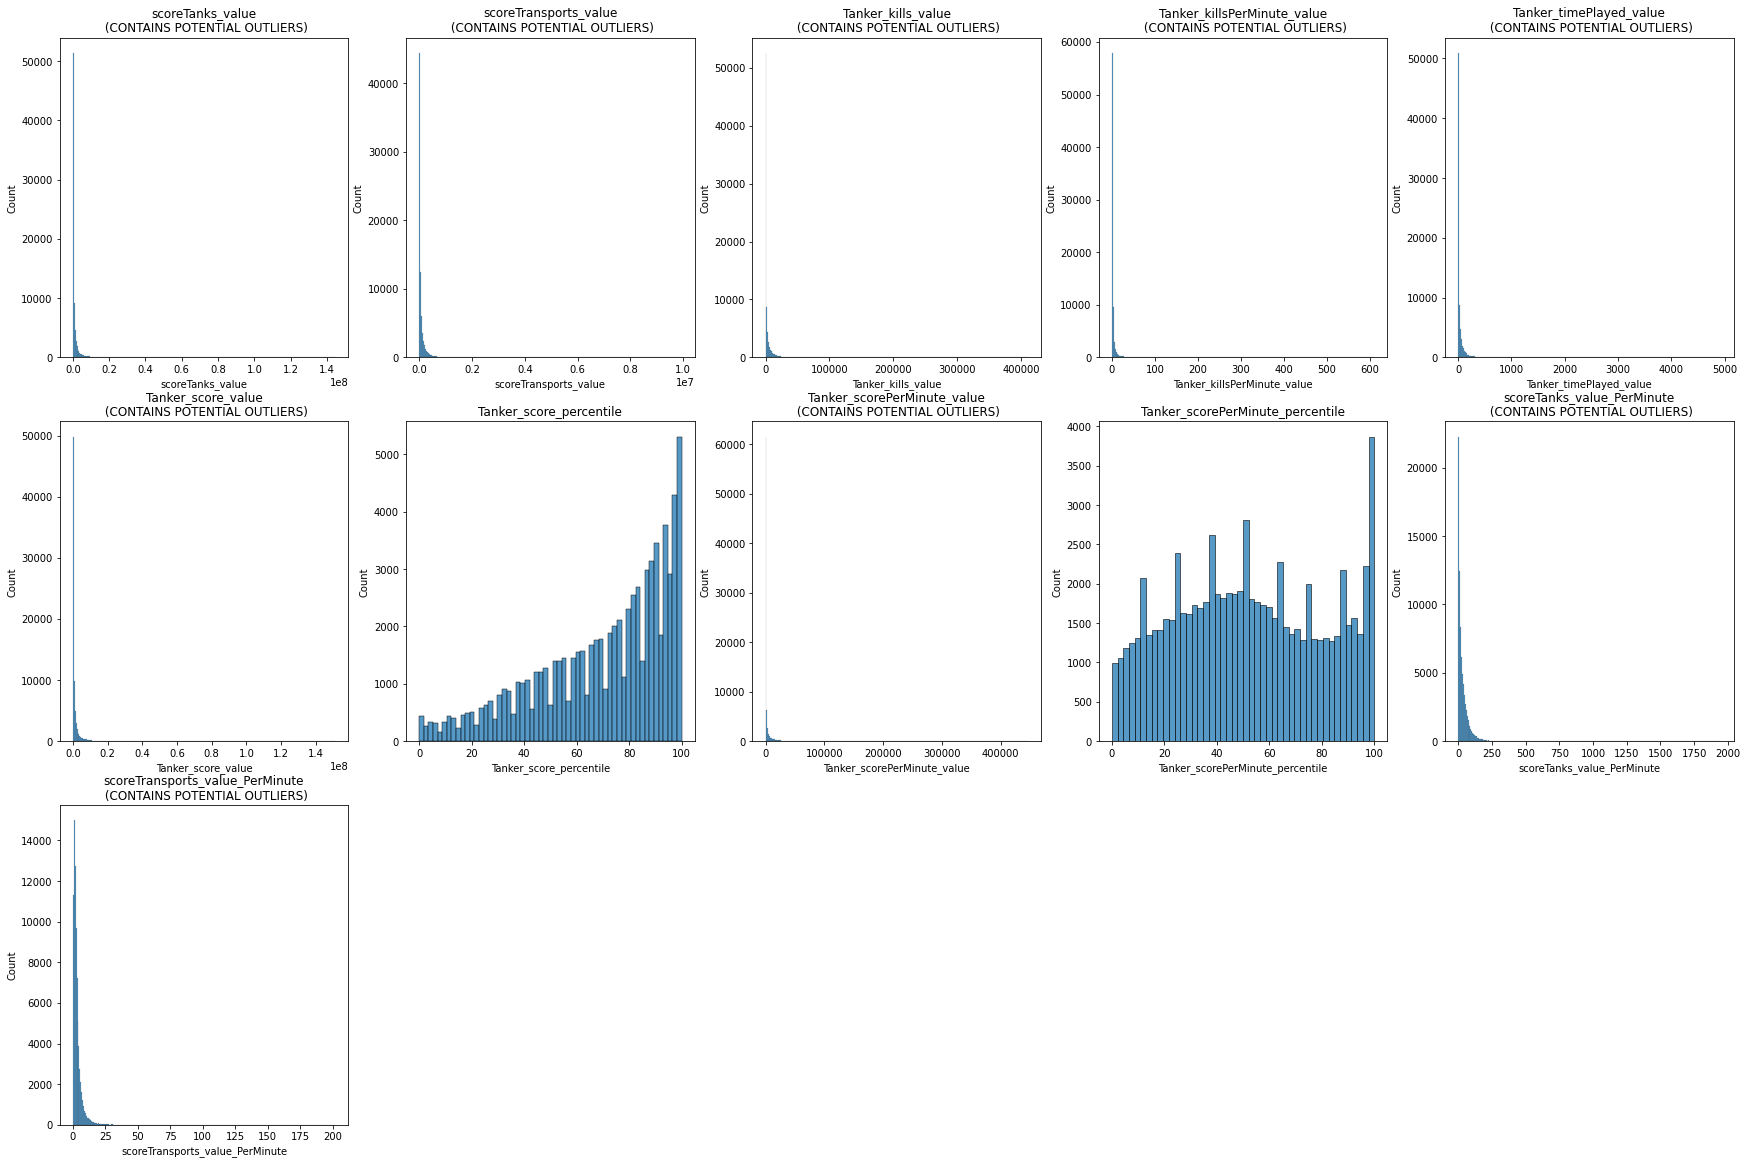

In [22]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), ground_vehicle_features):
    bins, max_range = get_n_bins(df, feat, 1000)
    
    if type(max_range) == str:
        sns.histplot(data=df, x=feat, ax=ax)
        ax.set_title(f'{feat}')
    else:
        sns.histplot(data=df, x=feat, ax=ax, bins=bins, binrange=(0, max_range*10))
        ax.set_title(f'{feat}\n (CONTAINS POTENTIAL OUTLIERS)')

for i, ax in enumerate(np.ravel(axes)):
        if i > len(ground_vehicle_features)-1:
            ax.axis('off')
            
plt.show()

The scale of the distributions here suggest outliers in many of the ground vehicle features.

## Plane Features
Planes, like ground vehicles, are less used relative to non-vehicle gameplay, and as such related features have long tails but may not contain outliers.

In [23]:
df[plane_features].describe()

,repairs_value,scoreAir_value,Pilot_kills_value,Pilot_deaths_value,Pilot_killsPerMinute_value,Pilot_kdRatio_value,Pilot_timePlayed_value,Pilot_shotsFired_value,Pilot_shotsHit_value,Pilot_shotsAccuracy_value,Pilot_score_value,Pilot_score_percentile,Pilot_scorePerMinute_value,Pilot_scorePerMinute_percentile,repairs_value_PerMinute,scoreAir_value_PerMinute
count,78369.000000,7.836900e+04,78362.000000,78362.0,78362.000000,78362.0,78362.000000,78362.0,78362.0,78362.0,7.836200e+04,75688.000000,78362.000000,75056.000000,78369.000000,78369.000000
mean,1435.496510,5.867495e+05,1644.870588,0.0,0.344118,0.0,29.572391,0.0,0.0,0.0,5.868018e+05,60.375773,221.688260,56.485545,0.057096,12.512556
std,3458.234242,2.648712e+06,7605.587935,0.0,2.692001,0.0,103.917026,0.0,0.0,0.0,2.648824e+06,29.372820,836.724941,29.360812,0.083200,32.828510
min,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,72.000000,6.700000e+02,0.000000,0.0,0.000000,0.0,0.126389,0.0,0.0,0.0,6.700000e+02,37.000000,49.740484,31.000000,0.006380,0.059435
50%,423.000000,5.083000e+03,6.000000,0.0,0.104842,0.0,1.216667,0.0,0.0,0.0,5.084000e+03,64.000000,103.750000,59.000000,0.029165,0.454144
75%,1417.000000,1.235870e+05,294.000000,0.0,0.407407,0.0,14.162153,0.0,0.0,0.0,1.236048e+05,87.000000,232.624144,84.000000,0.075592,6.972407
max,223658.000000,1.258103e+08,350572.000000,0.0,467.000000,0.0,3472.322222,0.0,0.0,0.0,1.258103e+08,99.900000,85318.000000,99.900000,3.068233,599.667017


We can see that some features do not contain any non-zero values. These features are not particularly useful and can be dropped. We see also potential outliers, like the large maximum value for Pilot_killsPerMinute_value.

In [24]:
useless_plane_features = [feat for feat in plane_features if len(df[df[feat].notna()][feat].unique()) == 1]
plane_features = [feat for feat in plane_features if feat not in useless_plane_features]
df = df.drop(useless_plane_features, axis=1)
useless_plane_features

['Pilot_deaths_value',
 'Pilot_kdRatio_value',
 'Pilot_shotsFired_value',
 'Pilot_shotsHit_value',
 'Pilot_shotsAccuracy_value']

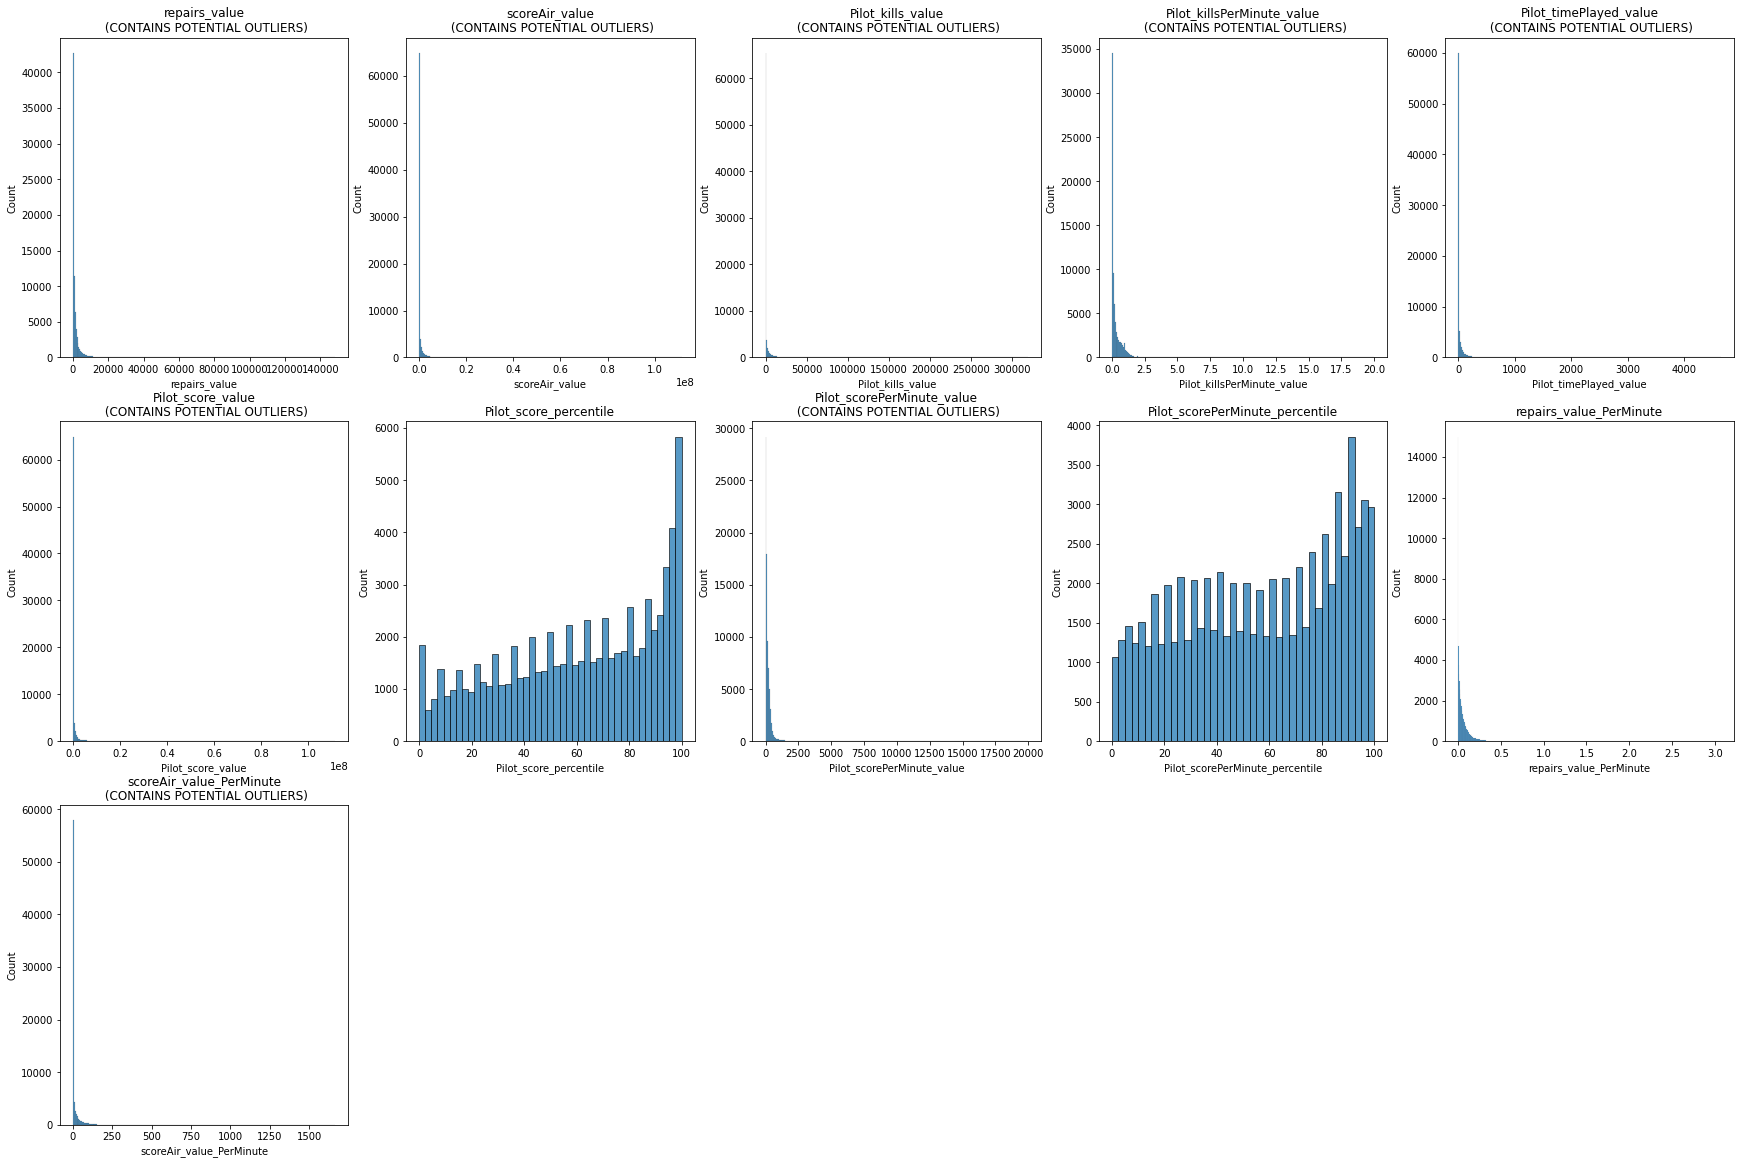

In [25]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), plane_features):
    bins, max_range = get_n_bins(df, feat, 1000)
    
    if type(max_range) == str:
        sns.histplot(data=df, x=feat, ax=ax)
        ax.set_title(f'{feat}')
    else:
        sns.histplot(data=df, x=feat, ax=ax, bins=bins, binrange=(0, max_range*10))
        ax.set_title(f'{feat}\n (CONTAINS POTENTIAL OUTLIERS)')

for i, ax in enumerate(np.ravel(axes)):
        if i > len(plane_features)-1:
            ax.axis('off')

## Correlations

In [26]:
high_corr = 0.5
corr_features = []
corr = df[df.columns[1:]].corr() # select only numerical features

# select only features with correlations above threshold of 0.5
for feature in corr.columns: # numerical columns only
    feat_max_corr = corr[corr[feature] < 1][feature].max() # Ignore correlations of one, since all correlations on the diagonal are 1
    feat_min_corr = corr[corr[feature] < 1][feature].min()
    if np.abs(feat_min_corr) > high_corr or feat_max_corr > high_corr:
        corr_features.append(feature)

print('The following portion of features have substantial (positive or negative) correlation with other features:', len(corr_features)/len(corr.columns))
large_corr = corr[corr_features].loc[corr_features]

The following portion of features have substantial (positive or negative) correlation with other features: 0.9245283018867925


We can immediately determine from the above that almost all of the features are fairly strongly correlated with at least one other feature. This is not particularly surprising. We have, for example, certain metrics that are tracked as totals as well as per minute values, which we would expect to be correlated. We also have features that are sums of other features, for example, we track overall score but also score gained defensively. Further, given knowledge of the game, we can expect certain scores to correlate with others. We would expect, for example, score per minute to correlate with kill death ratio, as getting more kills and dying less is an effective way to score more points per minute.

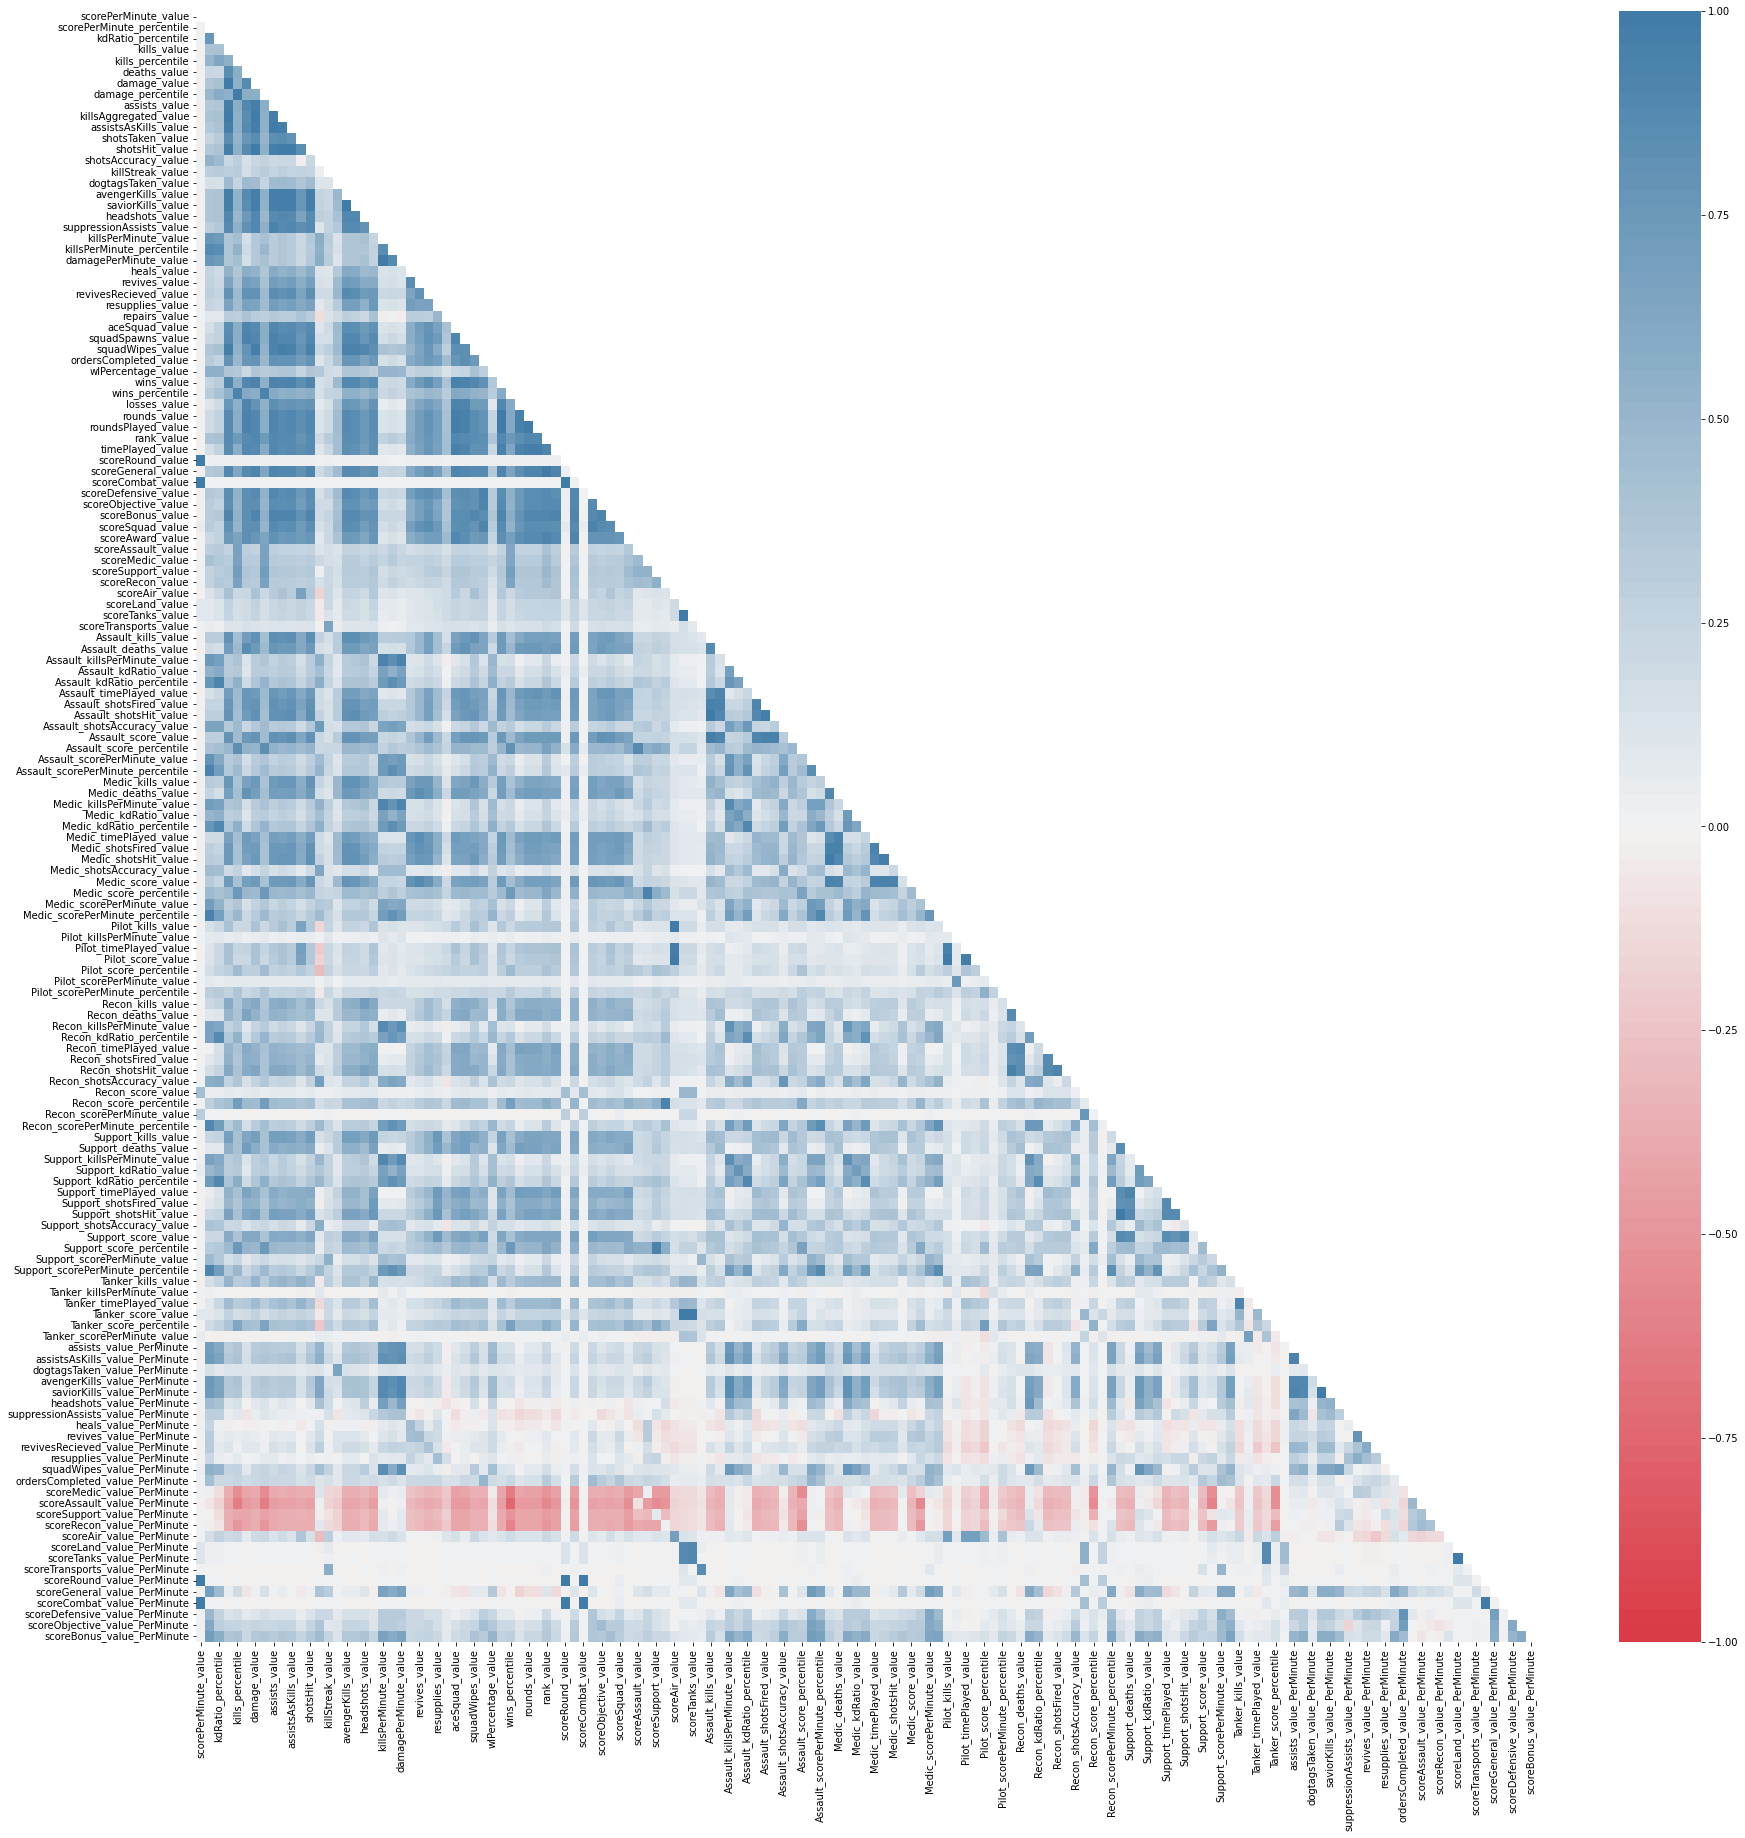

In [27]:
# Plotting correlations
mask = np.triu(large_corr)
cmap = sns.diverging_palette(10, 240, n=100)
plt.figure(figsize=(30,30))
sns.heatmap(large_corr,vmin=-1, vmax=1, cmap=cmap, mask=mask)
plt.show()

While the plot has not been marked up with values for specific correlations for the sake of readability, the phenomena discussed in the cell above the plot can be observed from looking at the plot.

It would be good to focus in on some features. To determine how to do this, I sum the absolute value of the correlation coeficients for each feature and subtract one (to account for the correlation between the feature and itself). I divide the sum by total number of features, for readability. I then sort the features by the value of that sum.

In [28]:
corr_sum = np.sum(np.abs(corr), axis=1) - 1
corr_sum = corr_sum.sort_values(ascending=False) / len(corr.columns)
print('Features with the highest total sum of absolute value of correlation coefficients')
corr_sum.head()

Features with the highest total sum of absolute value of correlation coefficients


rank_value               0.435046
damage_value             0.432366
killsAggregated_value    0.431252
kills_value              0.431013
scoreGeneral_value       0.428077
dtype: float64

In [29]:
print('Features with the smallest total sum of absolute value of correlation coefficients')
corr_sum.tail(20)

Features with the smallest total sum of absolute value of correlation coefficients


scoreTransports_value              0.086062
dogtagsTaken_value_PerMinute       0.083733
Recon_score_value                  0.082190
repairs_value_PerMinute            0.080810
Pilot_scorePerMinute_value         0.057332
scoreRound_value                   0.056870
aceSquad_value_PerMinute           0.051731
scoreSquad_value_PerMinute         0.050562
scoreLand_value_PerMinute          0.049404
scoreTanks_value_PerMinute         0.047746
scoreCombat_value                  0.047258
Pilot_killsPerMinute_value         0.046012
scorePerMinute_value               0.041345
scoreRound_value_PerMinute         0.041345
scoreCombat_value_PerMinute        0.041225
Tanker_scorePerMinute_value        0.038976
Recon_scorePerMinute_value         0.032328
Tanker_killsPerMinute_value        0.029869
scoreTransports_value_PerMinute    0.028021
kdRatio_value                      0.015160
dtype: float64

We can also plot a distribution of these sums.

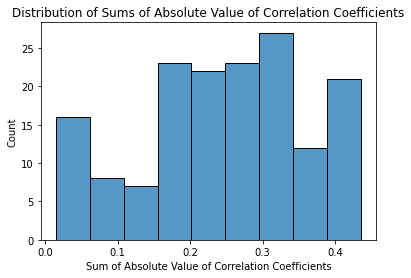

In [30]:
sns.histplot(corr_sum)
plt.xlabel('Sum of Absolute Value of Correlation Coefficients')
plt.ylabel('Count')
plt.title('Distribution of Sums of Absolute Value of Correlation Coefficients')
plt.show()

We can then plot heatmaps just looking at the twenty figures with the largest and smallest average correlation respectively and the features with which they correlate. First, the large average correlation features.

In [31]:
small_corr_features = corr_sum.tail(20).index
large_corr_features = corr_sum.head(20).index

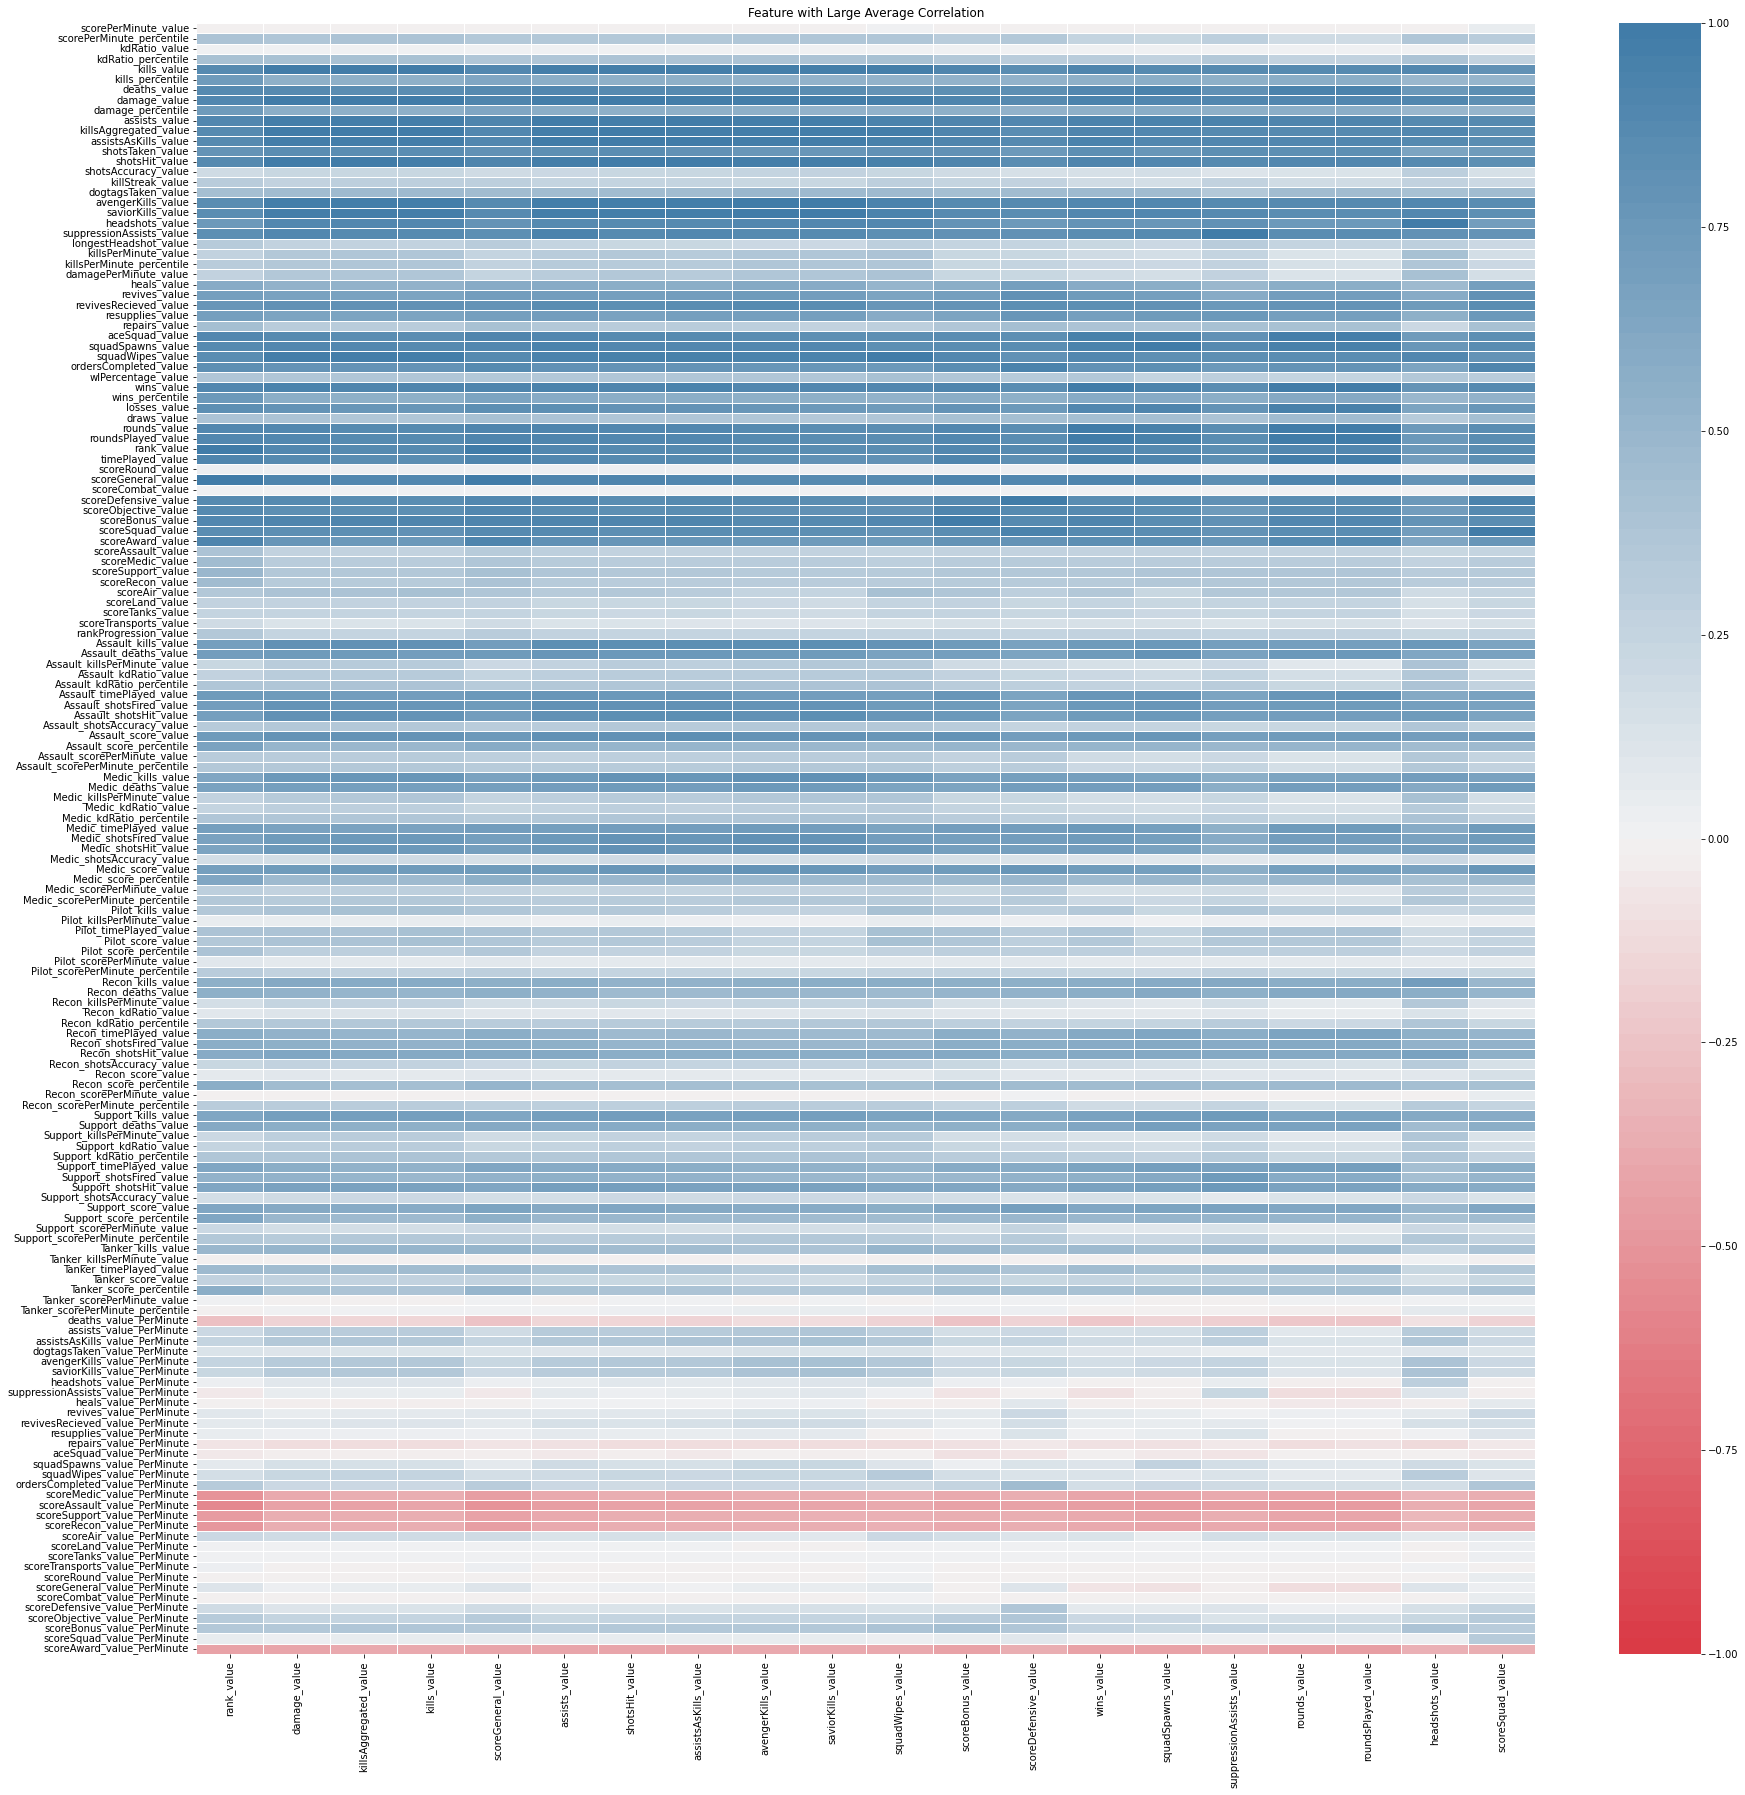

In [32]:
plt.figure(figsize=(30,30))
plt.title('Feature with Large Average Correlation')
sns.heatmap(corr[large_corr_features], vmin=-1, vmax=1, cmap=cmap, linewidths=0.5)
plt.show()

Next the features with small correlations.

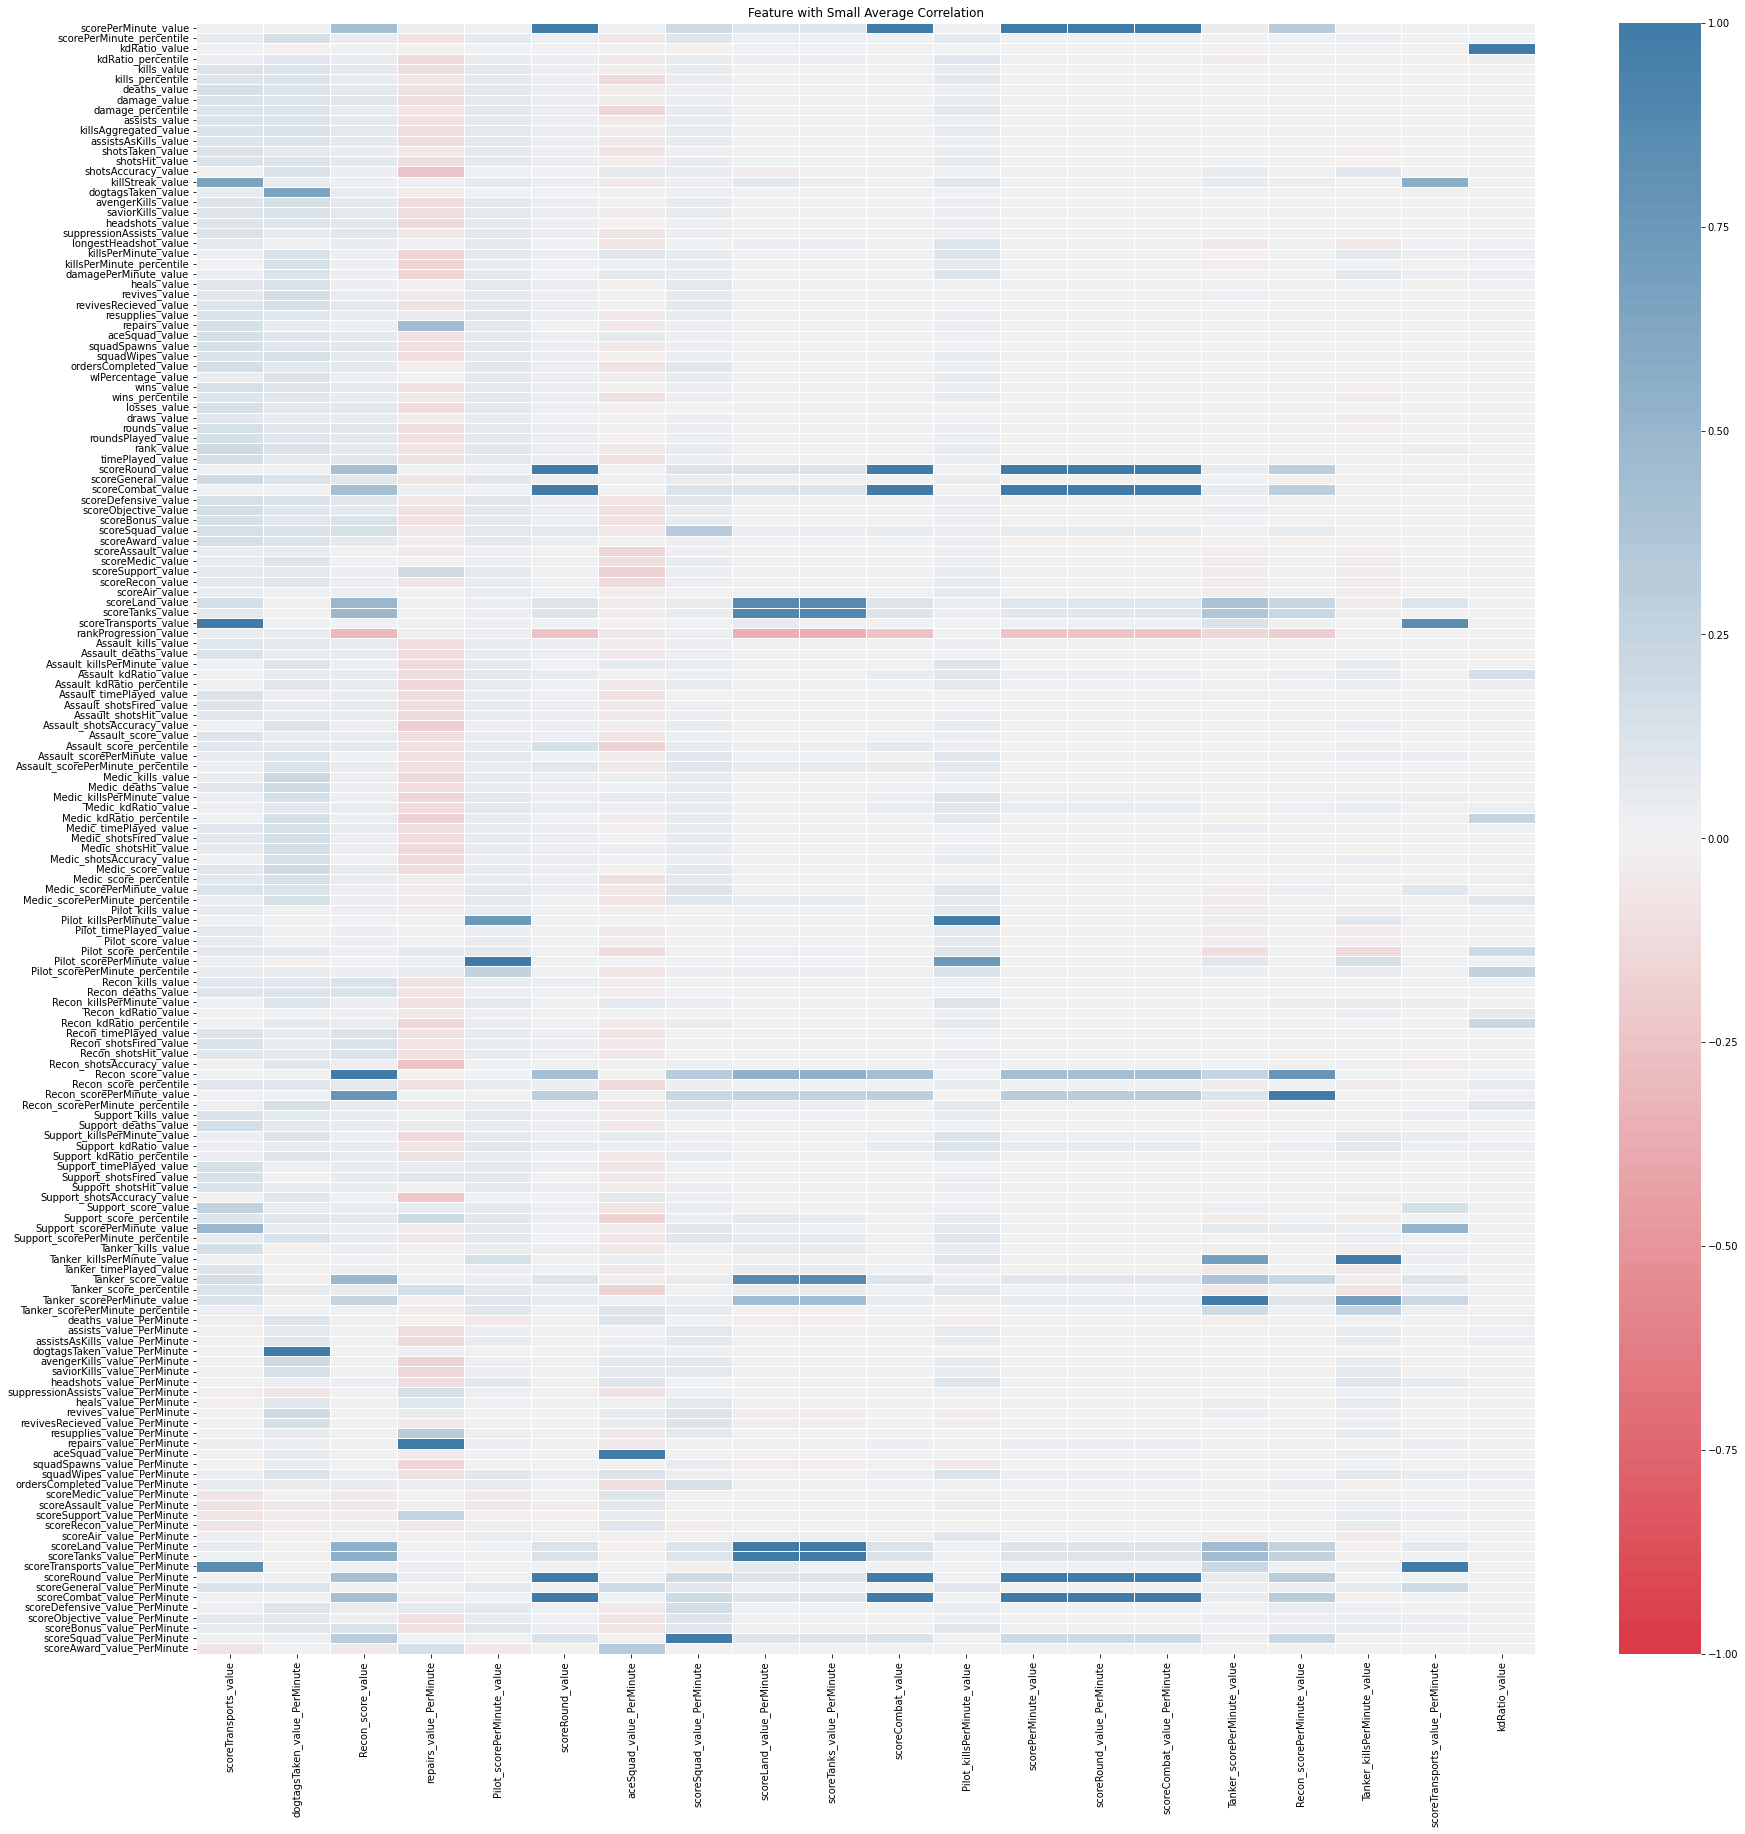

In [33]:
plt.figure(figsize=(30,30))
plt.title('Feature with Small Average Correlation')
sns.heatmap(corr[small_corr_features], vmin=-1, vmax=1, cmap=cmap, linewidths=0.5)
plt.show()

## Outliers
The game has a known problem with cheaters, for example, people who use aimbots. I would prefer to remove these players from the dataset, as they are not representative of average players' skills. I examine whether such players are in the dataset using basic statistical methods and domain knowledge. Given the fairly significant cheater problem in the game, I am fairly conservative at times.

One thing to note here is that raw values are going to be poor for detecting outliers by themselves. If I am terrible at the game but play 6 hours a day for years, I will likely have more kills than an excellent player who only plays 2 hours per week. However, they will likely have more kills per minute or kill death ratios. So when looking for outliers, I use features adjusted for time when possible.

Outlier detection is also crucial to guarantee performance of future tasks. For example, it is trivially clear that models relying on distance, like k-nearest neighbors or kmeans will be sensitive to outliers. This of course does not mean that we can remove samples with a large value in a feature simply because the value is large.

### Medic and Assault Score per Minute
Note here the features are features for the score of the class averaged over total playtime, not score for the class averaged over playtime for the class.

In [34]:
high_medic_support_score = df[(df['scoreAssault_value_PerMinute'] > 50) | (df['scoreMedic_value_PerMinute'] > 50)]
high_medic_support_score[['Medic_timePlayed_value', 'Assault_timePlayed_value', 'scoreAssault_value_PerMinute', 'scoreMedic_value_PerMinute']]

,Medic_timePlayed_value,Assault_timePlayed_value,scoreAssault_value_PerMinute,scoreMedic_value_PerMinute
5444,0.327778,3.937500,171.648000,15.586909
5945,23.408333,4.279167,154.699388,231.088288
25527,4.393056,3.473611,40.549051,96.604881
27047,7.736111,46.054167,70.749369,31.084914
34342,45.329167,54.240278,51.978631,51.978631
...,...,...,...,...
78363,3.170833,13.727778,244.378961,72.742502
78364,15.902778,2.552778,20.920082,176.590446
78365,2.643056,4.147222,63.354161,44.773956
78366,2.733333,8.604167,353.193305,124.106812


That value of score per minute is implausible and made even more so by the fact that it has only been achieved by 2 players with low playtimes in the classes for which their score per minute is high. Those samples are removed.

In [35]:
df = df[(df['scoreAssault_value_PerMinute'] < 50) & (df['scoreMedic_value_PerMinute'] < 50)]

### Medic and Support Accuracy
Some players have accuracy values with the medic and support class greater than or equal to 100, which should be impossible. These players are examined then removed.

In [36]:
df[(df['Support_shotsAccuracy_value'] >= 100)  | (df['Medic_shotsAccuracy_value'] >= 100)]

,platform,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,damage_value,damage_percentile,...,scoreTanks_value_PerMinute,scoreTransports_value_PerMinute,scoreRound_value_PerMinute,scoreGeneral_value_PerMinute,scoreCombat_value_PerMinute,scoreDefensive_value_PerMinute,scoreObjective_value_PerMinute,scoreBonus_value_PerMinute,scoreSquad_value_PerMinute,scoreAward_value_PerMinute
2737,psn,556.713934,96.9,3.875630,97.8,262198,99.9,67653,28235365,99.8,...,179.756219,0.659133,556.711282,533.288027,282.067442,84.783646,192.920674,81.437880,55.998775,44.349094
6208,origin,448.875556,87.0,2.041905,86.0,95359,98.7,46701,11835206,98.8,...,6.247949,1.384529,448.872219,514.194524,181.453592,103.375217,165.102307,77.627697,70.053287,71.565526
8699,psn,313.614959,49.0,2.428641,91.0,74382,98.0,30627,9282287,98.1,...,82.181553,1.790425,313.614404,404.845862,168.105976,64.121979,81.894537,45.271479,31.822285,46.268575
8852,psn,199.577917,14.0,3.217197,96.5,74980,98.0,23306,9281655,98.1,...,0.013504,0.002446,199.577917,263.317609,173.259168,25.411370,0.902128,28.062447,21.233931,50.825231
12726,psn,215.988639,17.0,1.605479,74.0,48463,96.3,30186,5872058,96.3,...,0.007541,0.000979,215.985995,333.803803,187.147999,28.388698,0.449298,29.069843,27.635763,88.747965
12746,xbl,421.173237,81.0,2.120341,87.0,58250,97.1,27472,7191342,97.2,...,72.875869,1.315082,421.168420,517.000366,228.047795,116.557802,76.799259,67.329938,54.879540,55.346768
13398,origin,402.768151,77.0,1.989561,85.0,59273,97.2,29792,6671597,96.8,...,0.776368,0.361034,402.763249,342.922616,217.705799,86.274220,98.721168,60.033952,43.082884,73.092790
19607,origin,565.794065,97.3,1.740373,78.0,44517,95.9,25579,4791111,95.2,...,2.770939,1.641597,565.781068,400.775946,195.840835,156.935907,213.070509,108.001929,108.279464,26.987834
19702,origin,504.310622,93.0,1.811954,80.0,43563,95.8,24042,5552065,96.0,...,4.254617,4.538232,504.305156,597.512293,189.754336,90.780670,223.862294,66.537222,63.013938,82.607913
20034,origin,567.473288,97.3,2.163468,88.0,44522,95.9,20579,4930928,95.4,...,1.984907,0.971002,567.459722,676.491541,241.777625,171.686958,154.013053,83.202843,87.250560,64.540087


They are all dropped from the dataset.

In [37]:
df = df[(df['Support_shotsAccuracy_value'] < 100)  & (df['Medic_shotsAccuracy_value'] < 100)]

### Class Kill Death Ratio
If asked, I would say that the player I know of with the best kill/death ratio has a kill/death ratio of about 5. This is an [outstanding player](https://battlefieldtracker.com/bfv/profile/psn/MaxiqYT/overview) with nearly 5000 hours played. They are essentially a minor celebrity for their kill/death ratio. So considering this as background, as well as general knowledge about Battlefield 5 specifically and FPS games in general, kill/death ratios of 6 or especially 7 and above strike me as essentially impossible to achieve with the so-called "infantry" classes in the game. One way this may be possible is if a player has a high k/d ratio for a class but low time playing the class. To examine the suspected outliers, I plot the kill/death ratio for each feature above a threshold of 6 against time played for the respective class.

In [38]:
[feat for feat in df.columns if 'time' in feat.lower()]

['timePlayed_value',
 'Assault_timePlayed_value',
 'Medic_timePlayed_value',
 'Pilot_timePlayed_value',
 'Recon_timePlayed_value',
 'Support_timePlayed_value',
 'Tanker_timePlayed_value']

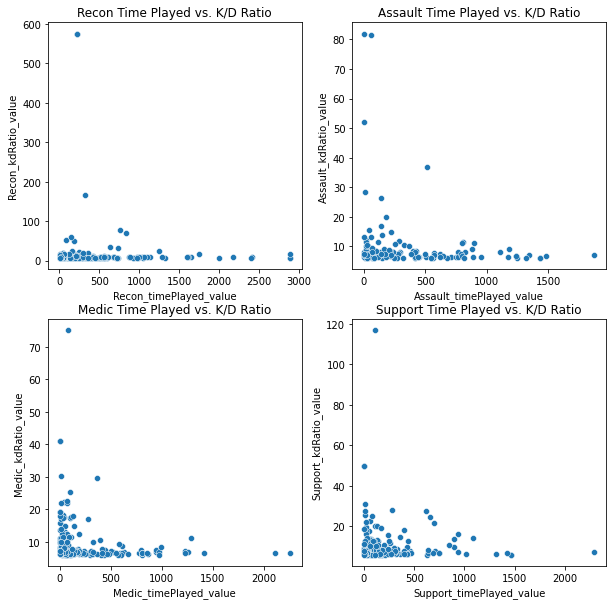

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
classes = ['Recon', 'Assault', 'Medic', 'Support']
for ax, infantry_class in zip(np.ravel(axes), classes):
    df_subset = df[df[f'{infantry_class}_kdRatio_value'] > 7][[f'{infantry_class}_timePlayed_value', f'{infantry_class}_kdRatio_value']]
    sns.scatterplot(data=df[df[f'{infantry_class}_kdRatio_value'] > 6], x=f'{infantry_class}_timePlayed_value', y=f'{infantry_class}_kdRatio_value', ax=ax)
    ax.set_title(f'{infantry_class} Time Played vs. K/D Ratio')
    
plt.show()

We see no strong relationship between time played for a various class and the kill/death ratio for the class. Further, noting that time played is given in hours, we also do not see the phenomena of a player having a very good kill/death ratio for a class but a very short time played for the class. As such, all of these outliers are removed.

In [40]:
for infantry_class in classes:
    df = df[df[f'{infantry_class}_kdRatio_value'] < 7]

### Tank Score per Minute
The distribution of score per minute for tanks immediately stands out. I do not know much about vehicles in the game, but I know that 1M score per minute is essentially impossible, especially sustained over a long period of time. Additionally, it is easier to get kills with planes, but the score per minute distribution in planes is much more reasonable.

In [41]:
tank_spm = df['Tanker_scorePerMinute_value']
tank_spm.describe()

count    5.327700e+04
mean     3.325782e+03
std      2.830082e+04
min      0.000000e+00
25%      4.409472e+02
50%      5.736334e+02
75%      9.827600e+02
max      2.463586e+06
Name: Tanker_scorePerMinute_value, dtype: float64

We can see here that most of the values are in the hundreds or low thousands, making the 1M score range value(s) look even more suspicious. To further examine them, I look only at values above the 3rd quartile.

In [42]:
num_best_tankers = len(df[tank_spm > 10_000])
print(f'Only {num_best_tankers} have a score per minute in tanks over 10,000.')
tank_spm[tank_spm > np.quantile(tank_spm, q=0.75)].describe()

Only 2588 have a score per minute in tanks over 10,000.


count    1.331900e+04
mean     1.172592e+04
std      5.576573e+04
min      9.827688e+02
25%      1.440544e+03
50%      2.644907e+03
75%      7.115037e+03
max      2.463586e+06
Name: Tanker_scorePerMinute_value, dtype: float64

We can see here that the top 25% of the top 25% players with the highest score per minute in tanks would be outstanding to maintain a score perminute of 10,000. I feel confident in treating the players above that threshold as outliers.

In [43]:
df = df[df['Tanker_scorePerMinute_value'] <= 10_000]

We can then revisualize the distribution of score per minute in tanks.

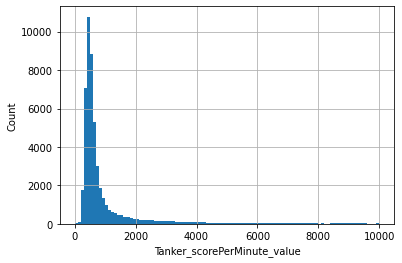

In [44]:
df['Tanker_scorePerMinute_value'].hist(bins=100)
plt.ylabel('Count')
plt.xlabel('Tanker_scorePerMinute_value')
plt.show()

This looks like what we expect based on the other plots.

#### Tank Kills per Minute
The tank kills per minute distribution also looks unusual. You can think of pilot kills per minute as a rough proxy for what the distribution for tanks should look like, except tank kills per minute should probably be lower. Getting hundreds of kills per minute is impossible for human players. Removing the score per minute outliers may have removed outliers in this feature, but it is best to check.

In [45]:
df['Tanker_killsPerMinute_value'].describe()

count    50689.000000
mean         1.850875
std          2.550784
min          0.000000
25%          0.996622
50%          1.321236
75%          1.840580
max        350.875000
Name: Tanker_killsPerMinute_value, dtype: float64

We see above that there is still at least one implausible value, 119. A sustained value of 119 kills per minute with tanks is impossible. I check values over 20 to get a general idea of how much of an outlier the maximum value is.

In [46]:
df[df['Tanker_killsPerMinute_value'] > 20]['Tanker_killsPerMinute_value']

1062     350.875000
3295      22.219512
3732      23.000000
6264      23.326733
8748      21.757576
8971     119.400000
20368     21.701299
21659     27.840000
22105     24.750000
22550     21.000000
23688     60.000000
24287     23.944767
26032     22.777778
26538     26.000000
27450     33.250000
29255     23.393939
32596     28.500000
33403     22.214286
34877     21.000000
35209     29.000000
37296     24.285714
37616     24.250000
38966     24.169811
39672     23.750000
40655     22.666667
43464     30.384615
46868     20.636364
47746     20.636364
48472     21.000000
49169     22.000000
49578     27.000000
49865     20.600000
50000     20.333333
52469     28.083333
52782     24.000000
53699     29.000000
53710     29.000000
54914     23.400000
61391     24.034483
62278     26.000000
67833     24.000000
68164     27.000000
69057     25.250000
72714     20.238095
73675     20.238095
77509     20.392857
Name: Tanker_killsPerMinute_value, dtype: float64

I remove the highest values manually. It is worth noting that other values here may be outliers worthy of removal, but I would have to ask someone more familiar with tank gameplay.

In [47]:
df = df[df['Tanker_killsPerMinute_value'] < 100]

### Tank Plots
Removing the outliers from the tank score per minute plots should have made them more readable, so I plot them again below.

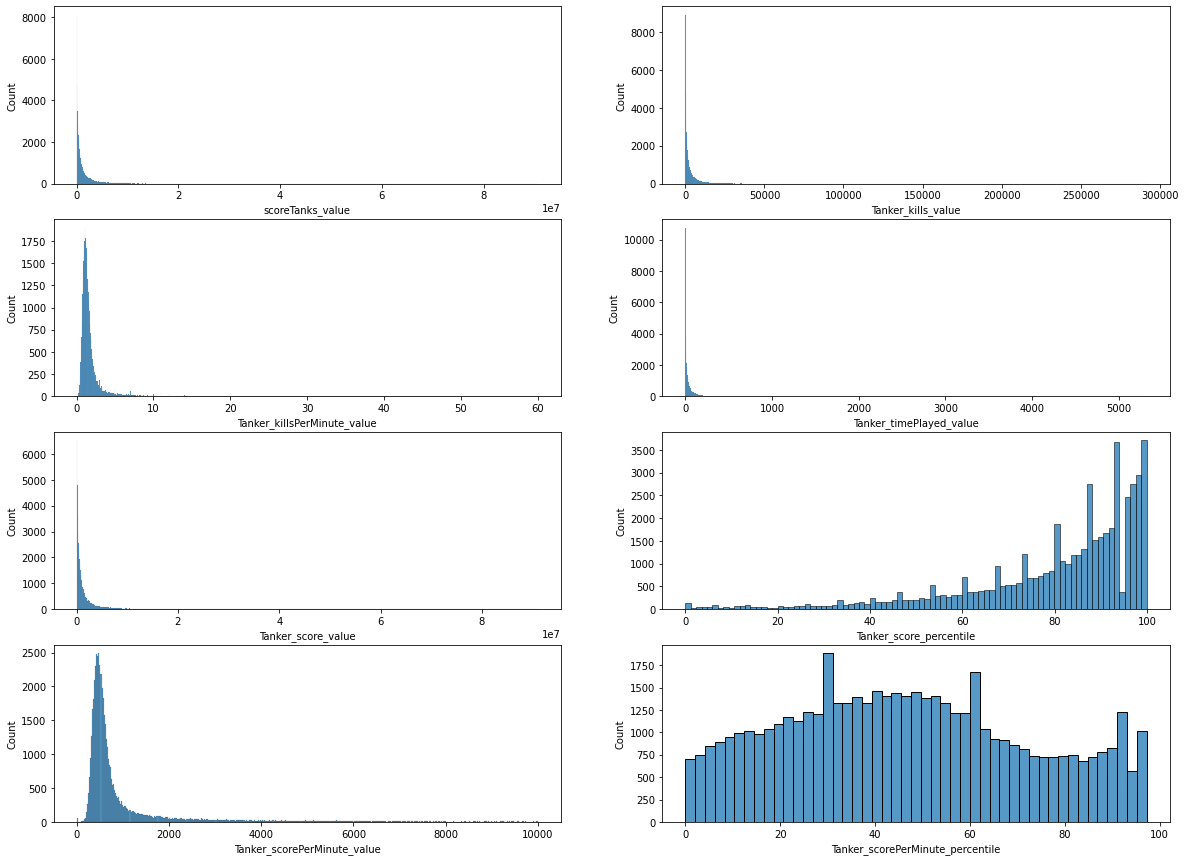

In [48]:
tank_features = [feature for feature in df.columns if 'tank' in feature.lower()]
fig, axes = plt.subplots(4,2, figsize=(20,15))

for ax, feature in zip(np.ravel(axes), tank_features):
    sns.histplot(data=df, x=feature, ax=ax)
plt.show()

### Plane Kills Per Minute
The Pilot_killsPerMinute_value feature has at least one value of around 250 kills per minute. This value is impossible to achieve. It and any other outliers will be removed.

In [49]:
df['Pilot_killsPerMinute_value'].describe()

count    50686.000000
mean         0.387239
std          2.598480
min          0.000000
25%          0.028571
50%          0.174157
75%          0.570111
max        467.000000
Name: Pilot_killsPerMinute_value, dtype: float64

We can see here that the maximum value really stands out, but I also check for other large values below.

In [50]:
df[df['Pilot_killsPerMinute_value'] <= 5]['Pilot_killsPerMinute_value'].describe()

count    50638.000000
mean         0.354440
std          0.434179
min          0.000000
25%          0.028319
50%          0.173847
75%          0.568779
max          5.000000
Name: Pilot_killsPerMinute_value, dtype: float64

In [51]:
df = df[df['Pilot_killsPerMinute_value'] < 5]

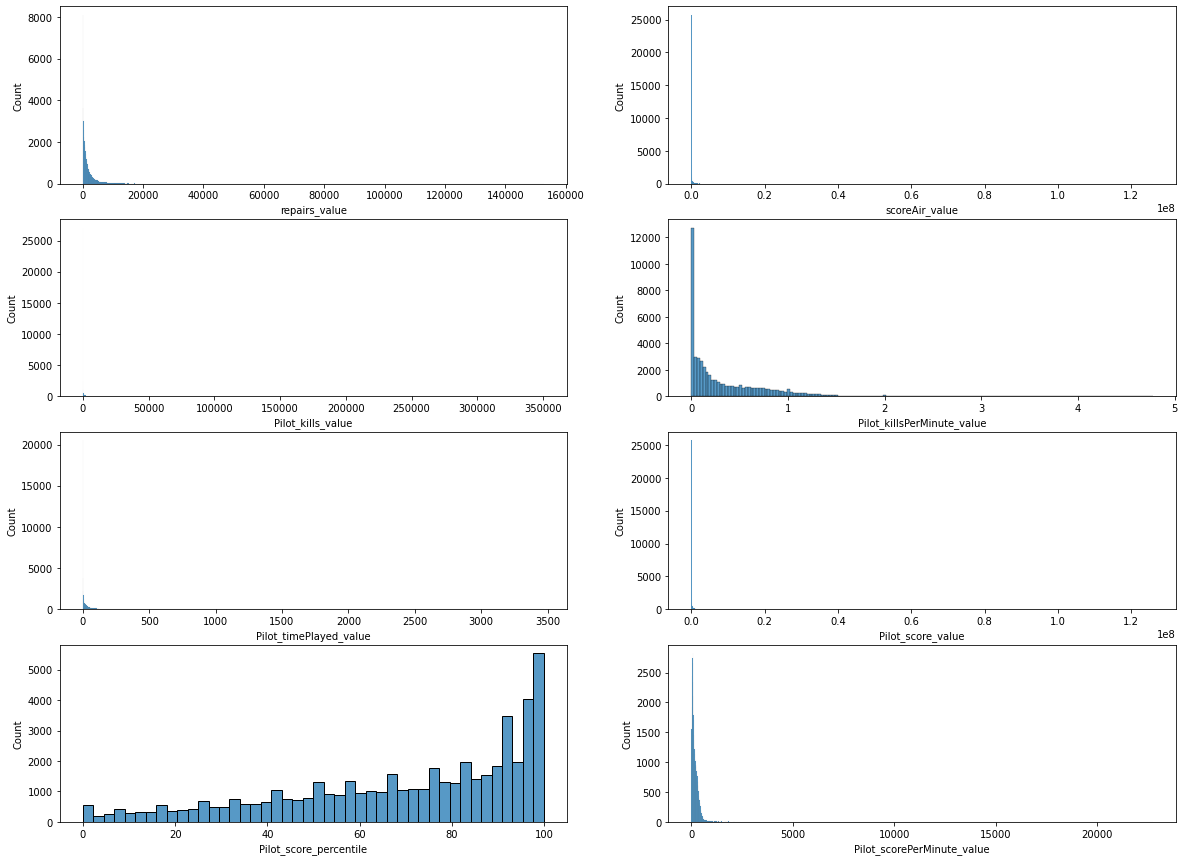

In [52]:
fig, axes = plt.subplots(4,2, figsize=(20,15))

for ax, feature in zip(np.ravel(axes), plane_features):
    sns.histplot(data=df, x=feature, ax=ax)
    
plt.show()

# Missing Values

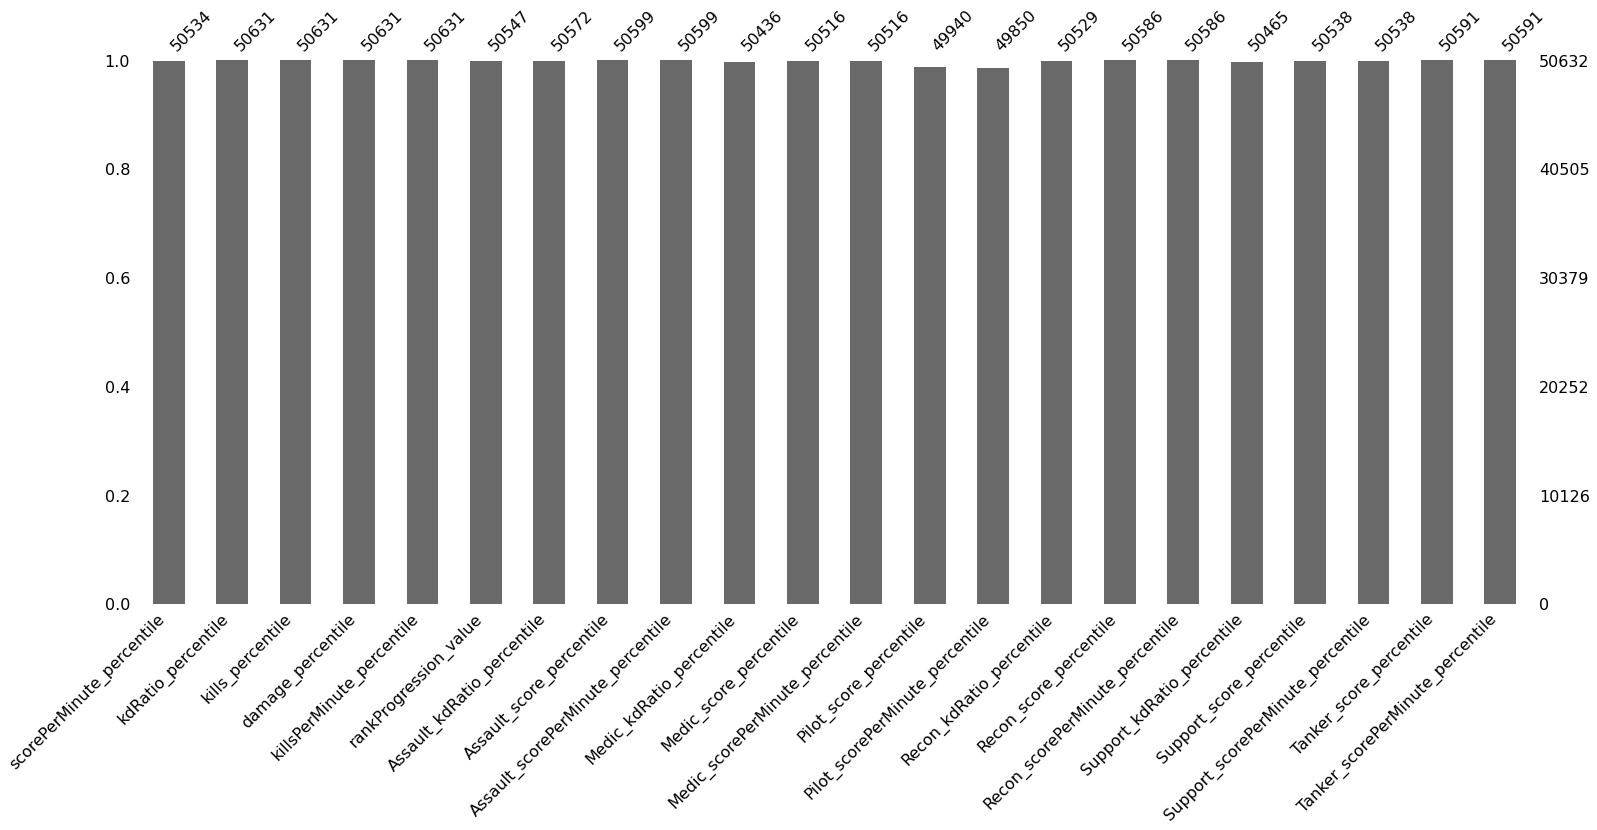

In [53]:
features_with_nan = [feature for feature in df.columns if df[feature].isnull().sum() > 0]
missingno.bar(df[features_with_nan])
plt.show()

There are few enough features that I simply replace missing values with the mean value of the feature.

In [54]:
for feature in features_with_nan:
    df[feature] = df[feature].fillna(df[feature].mean())